<a href="https://colab.research.google.com/github/nafisaaa1/Machine_Learning_course/blob/main/Nafiseh_Barmakhshad_Machine_Learning_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Applied Machine Learning - Basic & Advanced courses Final Project**

## **Student Name**: *Nafiseh Barmakhshad* - **Matricola:** *0001081190*

## **Supervised Machine Learning for Spotting and Sorting Cancer: An Entertaining Comparison**

###**Project Overview:**
This project delves into cancer detection and classification, employing supervised machine learning techniques. The model aims to predict cell health status and identify specific cancer types if present.

### **Objectives:**

*  **Predicting Tissue Health Status:**

  The primary objective is to train the model to predict whether a cell is healthy or cancerous based on labeled data comprising cellular characteristics and gene expressions.


*   **Discerning Specific Cancer Types:**

  In addition to identifying health status, the model is tasked with distinguishing between various cancer types.

*   **Exploring Diverse Machine Learning Algorithms:**

  The project conducts a comparative analysis of supervised machine learning algorithms, including Logistic regression, Random forrest, K-nearest neighbors (KNN), and Neural Networks.



###**Desirable Outcome:**


By carefully testing these methods on the given dataset, this project aims to find the best way to detect and classify cancer. The findings offer valuable insights into optimizing healthcare interventions in cancer management, potentially enhancing early detection and treatment outcomes.

**Import Required Libraries and Prepare Data**

In [3]:
import torch
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, roc_auc_score, precision_score, recall_score, f1_score, accuracy_score
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize, StandardScaler
from collections import Counter
import seaborn as sns
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score

# **1. Dataset Preparation**




Here is where the data can be accessed :  https://zenodo.org/records/7828660

named : **Subset of TCGA & GTEx**

 *published by Iñigo Prada-Luengo*

# **Dataset Description**
 The ***gtex_with_cancer.csv.gz*** file (368.6 MB) integrates data from the **GTEx** and **TCGA** projects.

**GTEx (Genotype-Tissue Expression)**: Provides genetic and expression data from various healthy human tissues. Samples are collected from deceased donors with no known diseases affecting the sampled tissues.

**TCGA (The Cancer Genome Atlas):** Offers detailed genetic and molecular information on different cancer types, identifying key mutations and features.Samples are obtained from cancer patients, including both tumor and matched normal tissues.


This dataset provides a valuable resource for researchers studying gene expression in healthy and cancerous tissues, facilitating the understanding of gene regulation and the molecular mechanisms underlying cancer.

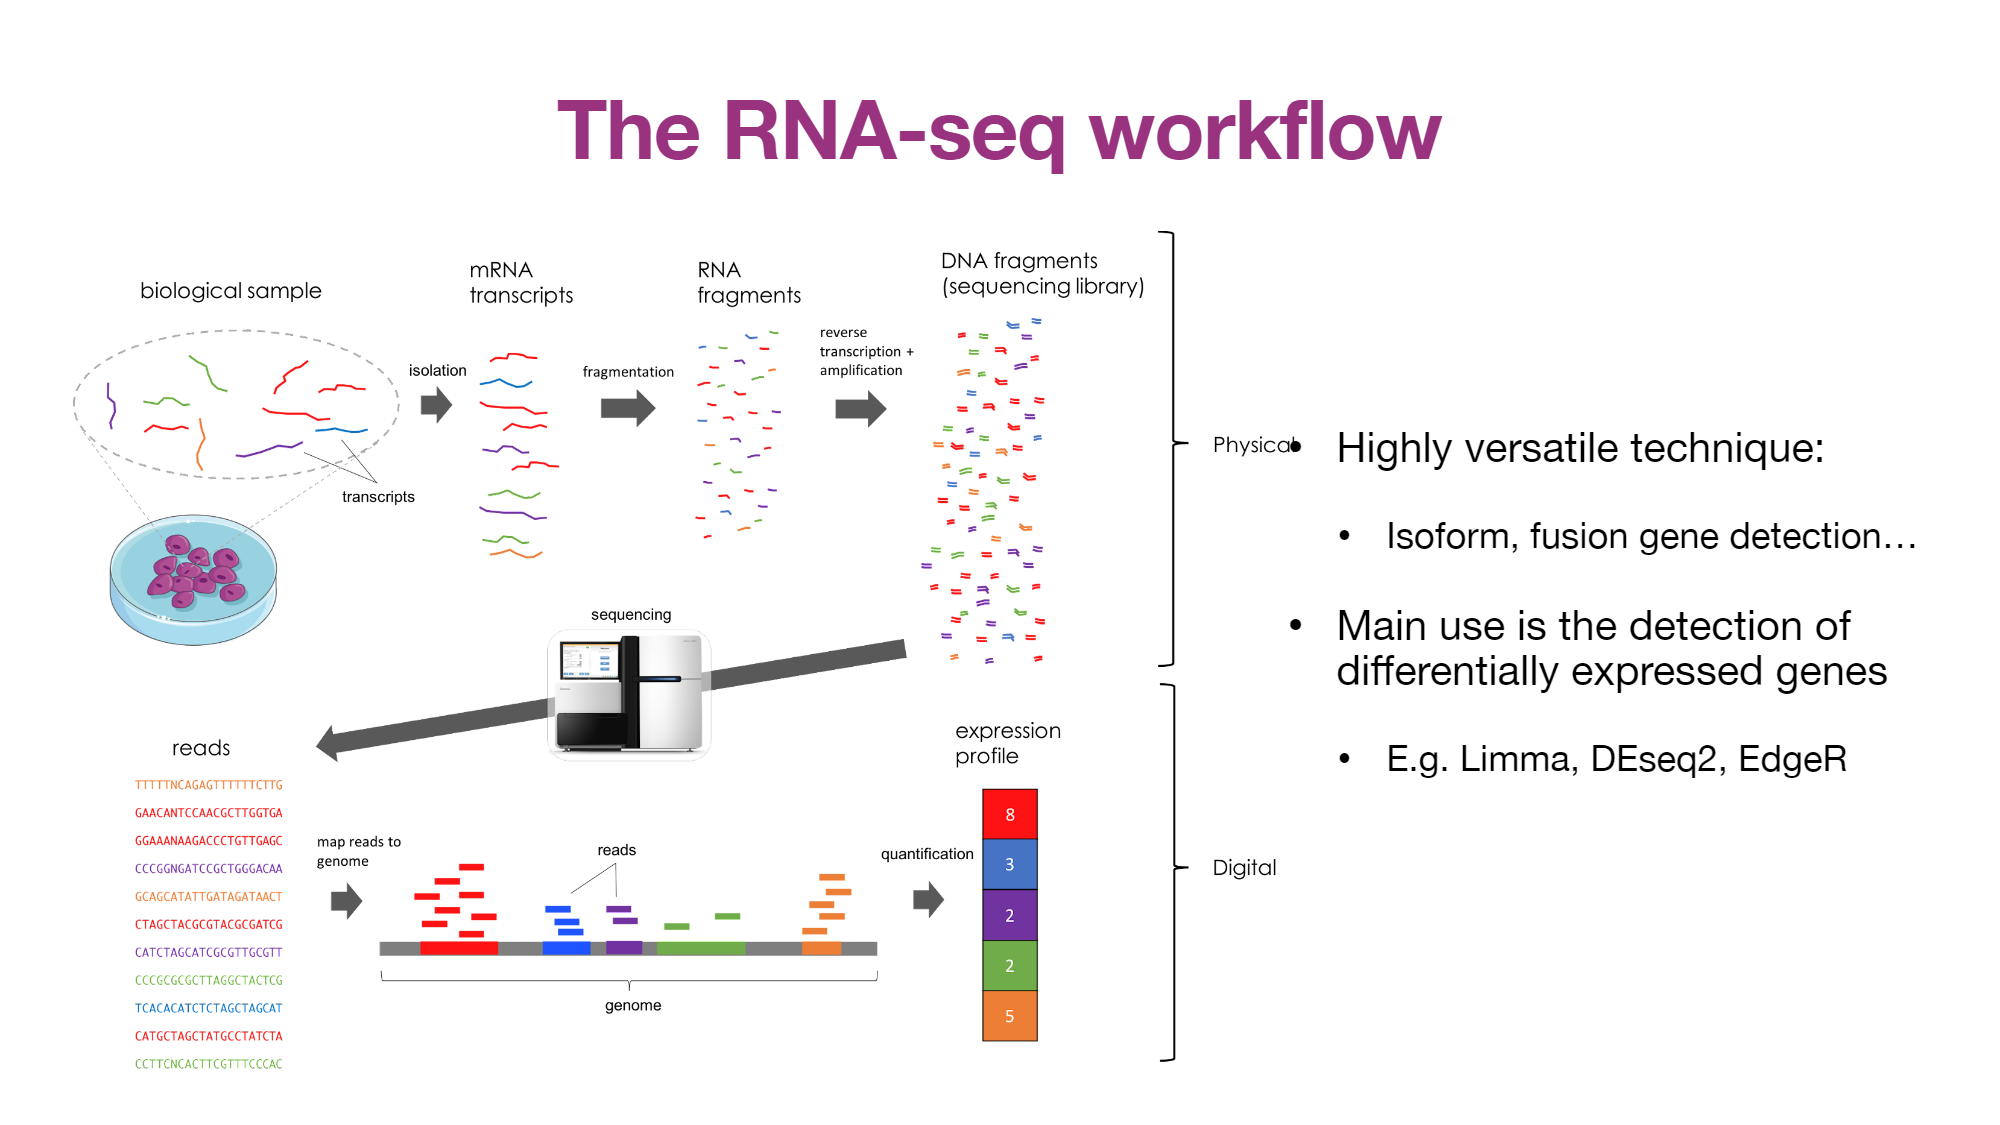


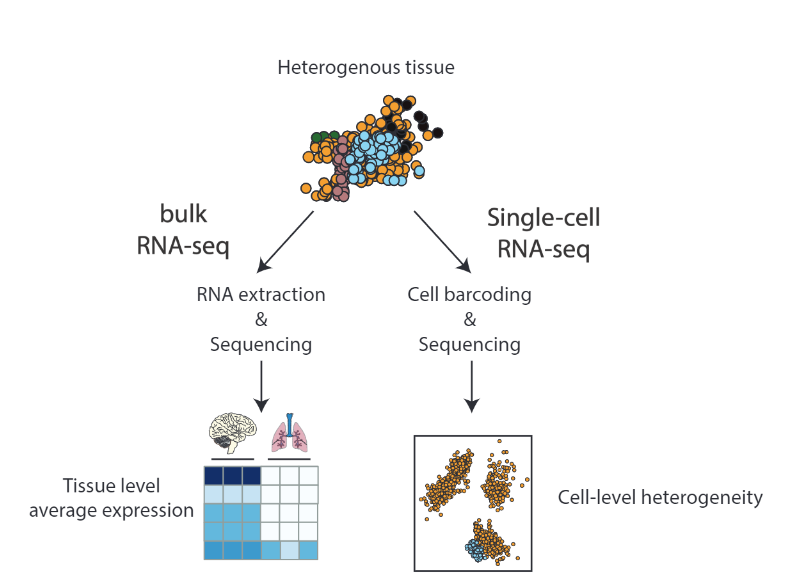

In [ ]:
#!wget https://zenodo.org/record/7828660/files/gtex_with_cancer.csv.gz

In [4]:
#to access files and directories stored in Google Drive directly from Colab

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Let's explore our dataset:**

In [5]:
# Load the dataset
data = pd.read_csv("drive/MyDrive/ML_course/final_project/gtex_with_cancer.csv.gz",sep="\t")

In [5]:
# Check different types of tissues present in the dataset
print("Tissues included in the dataset are: ", data['tissue'].unique())

Tissues included in the dataset are:  ['Adipose - Subcutaneous' 'Adipose - Visceral (Omentum)'
 'Muscle - Skeletal' 'Artery - Aorta' 'Artery - Tibial'
 'Artery - Coronary' 'Heart - Left Ventricle' 'Heart - Atrial Appendage'
 'Ovary' 'Uterus' 'Vagina' 'Breast - Mammary Tissue'
 'Skin - Sun Exposed (Lower leg)' 'Cells - Cultured fibroblasts'
 'Skin - Not Sun Exposed (Suprapubic)' 'Minor Salivary Gland'
 'Brain - Hypothalamus' 'Brain - Cortex'
 'Brain - Nucleus accumbens (basal ganglia)' 'Brain - Cerebellum'
 'Brain - Amygdala' 'Brain - Anterior cingulate cortex (BA24)'
 'Brain - Frontal Cortex (BA9)' 'Brain - Hippocampus'
 'Brain - Caudate (basal ganglia)' 'Brain - Putamen (basal ganglia)'
 'Brain - Cerebellar Hemisphere' 'Brain - Spinal cord (cervical c-1)'
 'Brain - Substantia nigra' 'Adrenal Gland' 'Thyroid' 'Lung' 'Spleen'
 'Pancreas' 'Esophagus - Gastroesophageal Junction' 'Esophagus - Mucosa'
 'Esophagus - Muscularis' 'Stomach' 'Colon - Transverse' 'Colon - Sigmoid'
 'Small Intesti

It seems the tissue lables representing the cancer case, include "carcinoma" or "adenocarcinoma" and the healthy ones just don't!

as machine learning algorithms expect numerical input for training, now I encode labels as numerical values (0 and 1)

In [6]:
# encode labels with 1 if it is cancerous and 0 if it is healthy and add a lable column to the data frame
data['label'] = [1 if 'carcinoma' in x or 'adenocarcinoma' in x else 0 for x in data['tissue']]

Now Let's visualise the frequency of each label and highlight the cancer cases

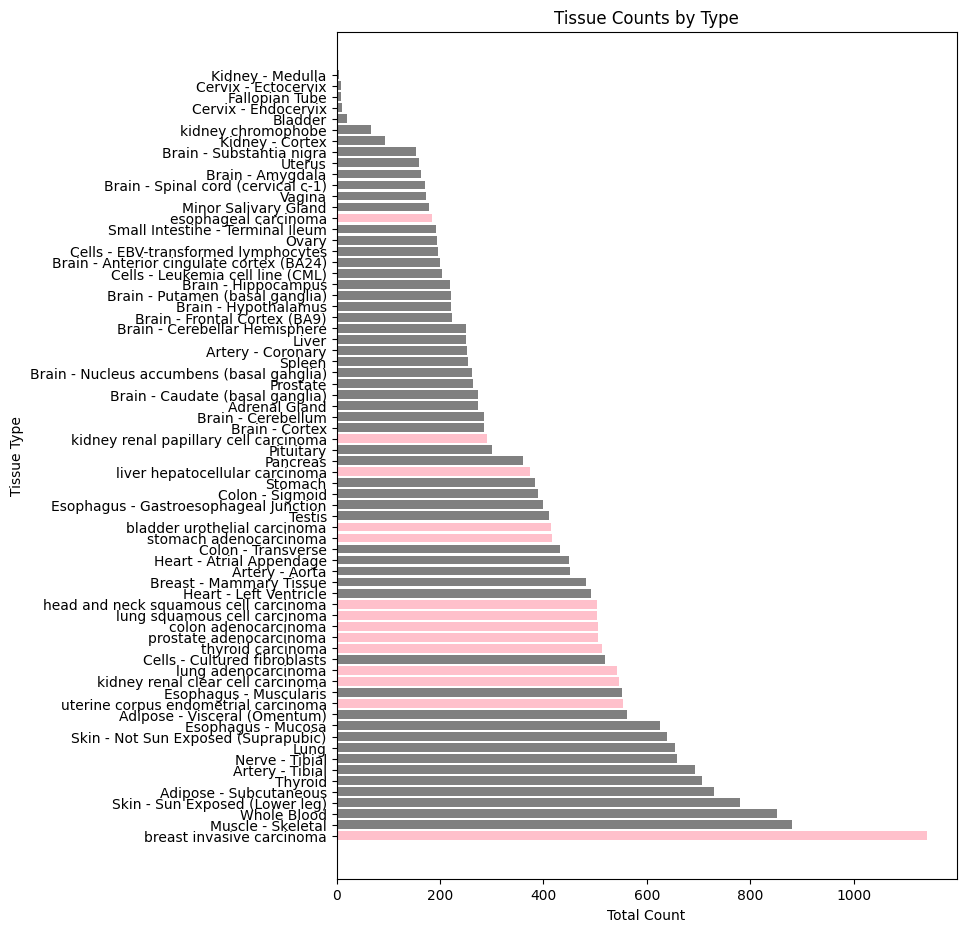

In [7]:
# Count the tissue occurrences
tissue_counts = data['tissue'].value_counts()

# Create a color list based on the label
colors = []
for tissue in tissue_counts.index:
    if any(data[data['tissue'] == tissue]['label'] == 1):
        # Check if any row with this tissue has label 1 (indicating cancer)
        colors.append('pink')  # Use a highlight color for cancer tissues
    else:
        colors.append('grey')  # Default color for tissues with label 0

# Create a horizontal bar chart
plt.figure(figsize=(8, 11))
bars = plt.barh(tissue_counts.index, tissue_counts.values, color=colors)

# Add title and axis labels
plt.title('Tissue Counts by Type')
plt.xlabel('Total Count')  # on the x-axis
plt.ylabel('Tissue Type')  # on the y-axis

# Show plot
plt.show()


## **Take out a Data Subset**

I like to work with high counts data only! Why?

 Maybe I can trust them better! given:

**Statistical Reliability:** Larger sample sizes provide more accurate and stable results, reducing the impact of outliers.

**Better Representation:** High-count datasets better capture the variability within tissue types, leading to more generalizable findings.

**Improved Model Performance:** Machine learning models perform better with more data, avoiding overfitting and ensuring robust evaluation.

**Comprehensive Insights:** More samples offer detailed biological insights, improving understanding and targeted intervention as in here, highest expressions are also the highest identifying the tissue specificity.


In [8]:
#Subdata with counts above 250
tissue_counts_filtered = tissue_counts[tissue_counts >= 250]
high_count_tissues = tissue_counts_filtered.index.tolist()
data_high_counts = data[data['tissue'].isin(high_count_tissues)]
print("Filtered dataset with high count tissues", data_high_counts.shape)


Filtered dataset with high count tissues (22872, 5002)


In [9]:
# Filter the DataFrame to include only rows where the label is 1 (indicating cancer)
cancer_data = data_high_counts[data_high_counts['label'] == 1]

# Count occurrences of each unique tissue label
cancer_counts = cancer_data['tissue'].value_counts()

# Sort the results from most frequent to least
sorted_cancer_counts = cancer_counts.sort_values(ascending=False)

# Print the name of the cancer tissue and its count
for tissue, count in sorted_cancer_counts.items():
    print(f"Tissue: {tissue}, Count: {count}")

Tissue: breast invasive carcinoma, Count: 1142
Tissue: uterine corpus endometrial carcinoma, Count: 554
Tissue: kidney renal clear cell carcinoma, Count: 546
Tissue: lung adenocarcinoma, Count: 542
Tissue: thyroid carcinoma, Count: 513
Tissue: prostate adenocarcinoma, Count: 506
Tissue: colon adenocarcinoma, Count: 505
Tissue: head and neck squamous cell carcinoma, Count: 504
Tissue: lung squamous cell carcinoma, Count: 504
Tissue: stomach adenocarcinoma, Count: 416
Tissue: bladder urothelial carcinoma, Count: 414
Tissue: liver hepatocellular carcinoma, Count: 374
Tissue: kidney renal papillary cell carcinoma, Count: 291


Now, I want to compare each cancer type to it's relative normal healthy tissue. For this aim, a closer check is required

In [10]:
# Filter the DataFrame to include only rows where the label is 0 (indicating normal tissue) but for all data not only high counts
normal_data = data[data['label'] == 0]

# Count occurrences of each unique tissue label
normal_counts = normal_data['tissue'].value_counts()

# Sort the results from most frequent to least
sorted_normal_counts = normal_counts.sort_values(ascending=False)

# Print the name of the normal tissue and its count
#for tissue, count in sorted_normal_counts.items():
#    print(f"Tissue: {tissue}, Count: {count}")

In [11]:
# Concatenate cancer and normal datasets into a single DataFrame
combined_data = pd.concat([cancer_data, normal_data], ignore_index=True)


As I want to be sure about the normal and cancer cases, this step checked manually, since the spelling could differ in each type


```
#1.Breast
#cancer: breast invasive carcinoma, Count: 1142                                   >>> normal: Breast - Mammary Tissue, Count: 482
breast_cancer = data[data['tissue'] == "breast invasive carcinoma"]
breast_normal = data[data['tissue'] == "Breast - Mammary Tissue"]

#2.Uteine
#cancer: uterine corpus endometrial carcinoma, Count: 554            >>> normal: Uterus, Count: 159
uterine_cancer = data[data['tissue'] == "uterine corpus endometrial carcinoma"]
uterine_normal = data[data['tissue'] == "Uterus"]

#3.Kidney
#cancer_1: kidney renal clear cell carcinoma, Count: 546
#cancer_2: kidney renal papillary cell carcinoma, Count: 291
#                                                                        >>> normal_1: Kidney - Cortex, Count: 94
#                                                                        >>> normal_2: kidney chromophobe, Count: 66
#
kidney_cancer1 = data[data['tissue'] == "kidney renal clear cell carcinoma"]
kidney_cancer2 = data[data['tissue'] == "kidney renal papillary cell carcinoma"]
kidney_normal1 = data[data['tissue'] == "Kidney - Cortex"]
kidney_normal2 = data[data['tissue'] == "kidney chromophobe"]

#4.Lung
#cancer_1: lung adenocarcinoma, Count: 542                             >>> normal: Lung, Count: 655
#cancer_2: lung squamous cell carcinoma, Count: 504
lung_cancer1 = data[data['tissue'] == "lung adenocarcinoma"]
lung_cancer2 = data[data['tissue'] == "lung squamous cell carcinoma"]
lung_normal = data[data['tissue'] == "Lung"]

#5.Thyroid
#cancer: thyroid carcinoma, Count: 513                               >>> normal: Thyroid, Count: 706
thyroid_cancer = data[data['tissue'] == "thyroid carcinoma"]
thyroid_normal = data[data['tissue'] == "Thyroid"]

#6.Prostate
#cancer: prostate adenocarcinoma, Count: 506                         >>> normal: Prostate, Count: 263
prostate_cancer = data[data['tissue'] == "prostate adenocarcinoma"]
prostate_normal = data[data['tissue'] == "Prostate"]

#7.Colon
#cancer: colon adenocarcinoma, Count: 505                            >>> normal_1: Colon - Transverse, Count: 433
#                                                                    >>> normal_2: Colon - Sigmoid, Count: 389
colon_cancer = data[data['tissue'] == "colon adenocarcinoma"]
colon_normal1 = data[data['tissue'] == "Colon - Transverse"]
colon_normal2 = data[data['tissue'] == "Colon - Sigmoid"]

#8.Stomach
#cancer: stomach adenocarcinoma, Count: 416                          >>> normal:: Stomach, Count: 384
stomach_cancer = data[data['tissue'] == "stomach adenocarcinoma"]
stomach_normal = data[data['tissue'] == "Stomach"]

#9.Liver
#cancer: liver hepatocellular carcinoma, Count: 374                  >>> normal:: Liver, Count: 251
liver_cancer = data[data['tissue'] == "liver hepatocellular carcinoma"]
liver_normal = data[data['tissue'] == "Liver"]
```



## **Define Cancer and Normal Datasets**

In [12]:
# Define cancer and normal datasets
string_datasets = {
    "Breast": {"cancer": "breast invasive carcinoma", "normal": "Breast - Mammary Tissue"},
    "Uterine": {"cancer": "uterine corpus endometrial carcinoma", "normal": "Uterus"},
    "Kidney": {"cancer_1": "kidney renal clear cell carcinoma", "cancer_2": "kidney renal papillary cell carcinoma", "normal_1": "Kidney - Cortex", "normal_2": "kidney chromophobe"},
    "Lung": {"cancer_1": "lung adenocarcinoma","cancer_2": "lung squamous cell carcinoma", "normal": "Lung"},
    "Thyroid": {"cancer": "thyroid carcinoma", "normal": "Thyroid"},
    "Prostate": {"cancer": "prostate adenocarcinoma", "normal": "Prostate"},
    "Colon": {"cancer": "colon adenocarcinoma", "normal_1": "Colon - Transverse",  "normal_2": "Colon - Sigmoid"},
    "Stomach": {"cancer": "stomach adenocarcinoma", "normal": "Stomach"},
    "Liver": {"cancer": "liver hepatocellular carcinoma", "normal": "Liver"}
}

# Define colors
colors = {
    "color_breast_cancer": "navajowhite",
    "color_breast_normal": "tan",
    "color_uterine_cancer": "darkgreen",
    "color_uterine_normal": "yellowgreen",
    "color_kidney_cancer_1": "darkorange",
    "color_kidney_cancer_2": "goldenrod",
    "color_kidney_normal_1": "gold",
    "color_kidney_normal_2": "yellow",
    "color_lung_cancer_1": "lightpink",
    "color_lung_cancer_2": "skyblue",
    "color_lung_normal": "crimson",
    "color_thyroid_cancer": "navy",
    "color_thyroid_normal": "dodgerblue",
    "color_prostate_cancer": "purple",
    "color_prostate_normal": "mediumorchid",
    "color_colon_cancer": "sienna",
    "color_colon_normal_1": "sandybrown",
    "color_colon_normal_2": "peru",
    "color_stomach_cancer": "firebrick",
    "color_stomach_normal": "indianred",
    "color_liver_cancer": "darkcyan",
    "color_liver_normal": "lightseagreen"
}

## **Visualization**

I have fun with colorful plots ✌

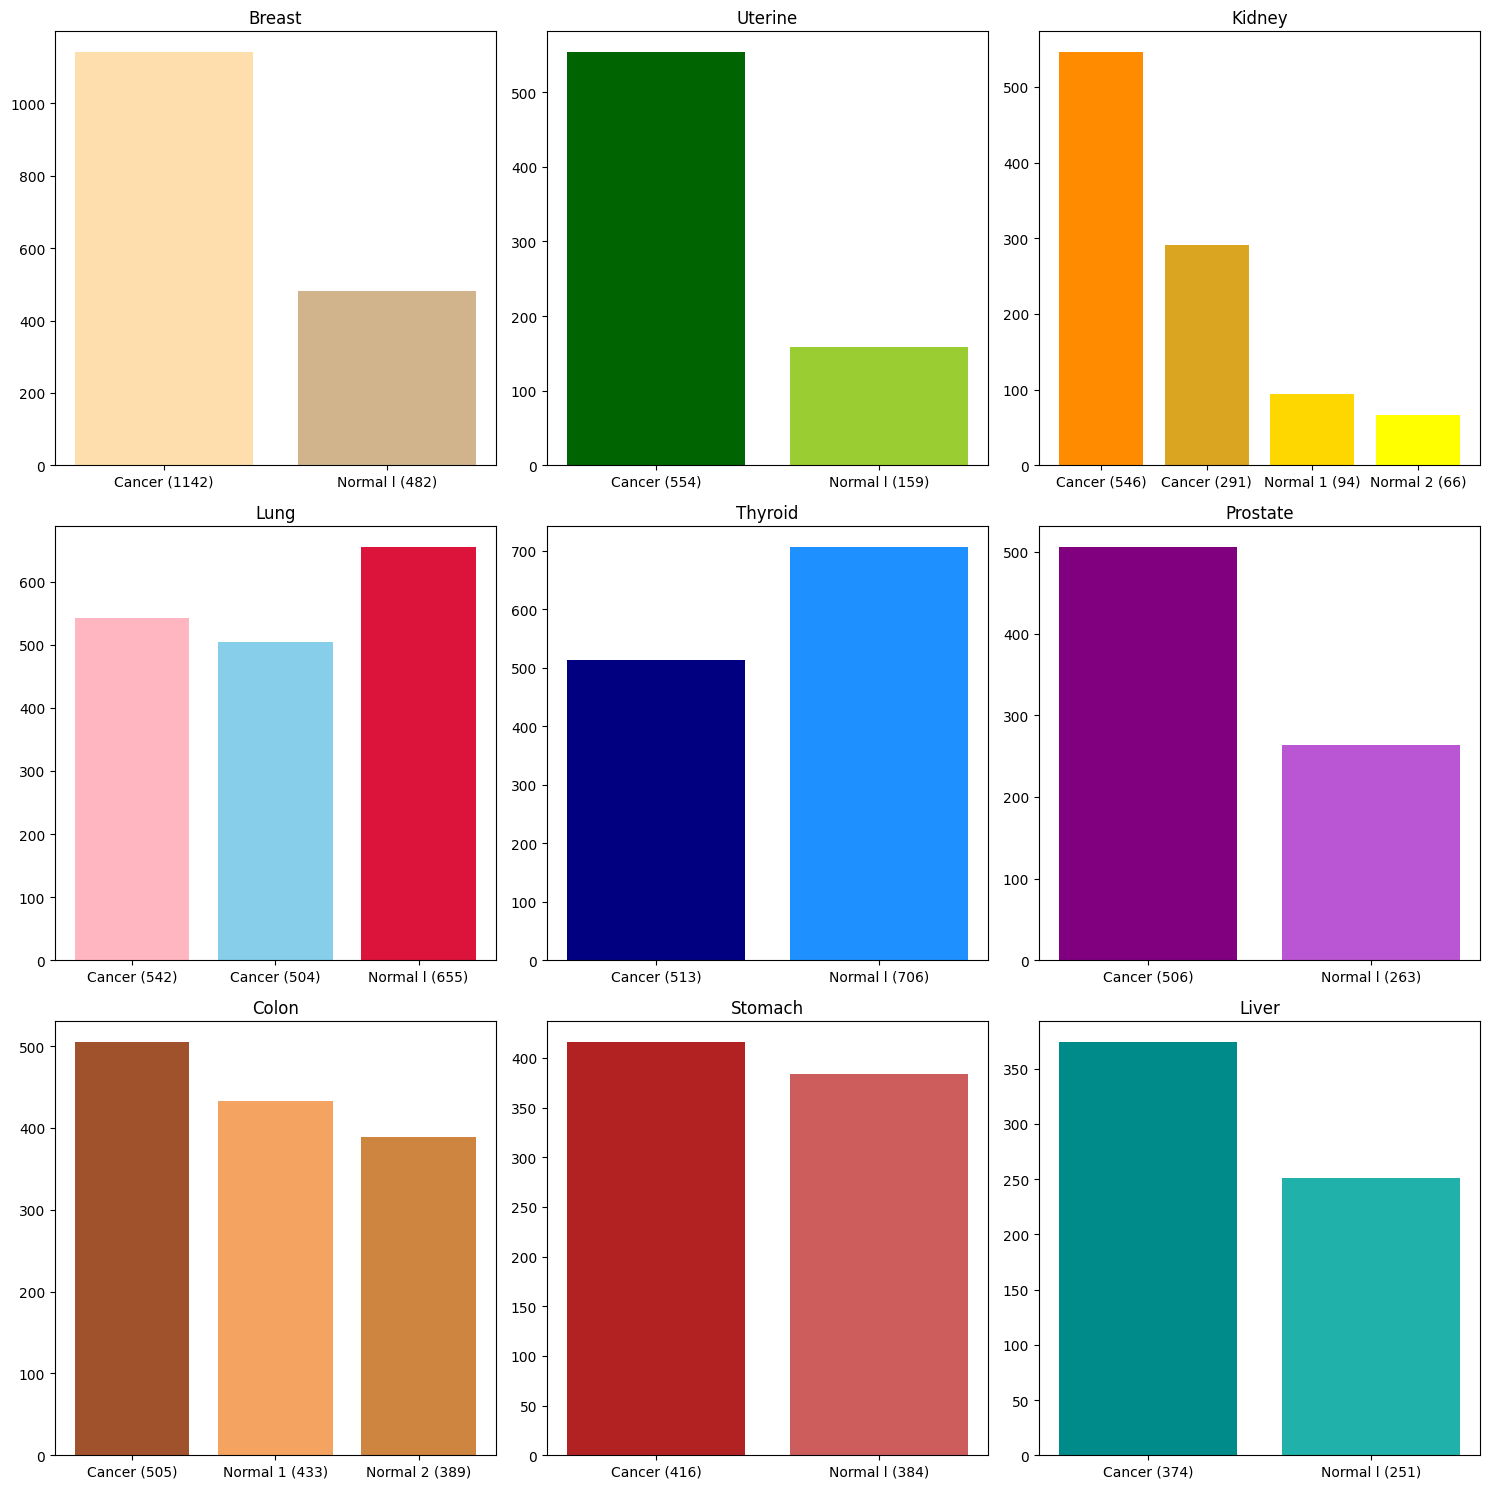

In [13]:
# Plot each dataset colorfully!
fig, axs = plt.subplots(3, 3, figsize=(15, 15))

for i, (title, string_datasets) in enumerate(string_datasets.items()):
    ax = axs[i//3, i%3]
    cancer_count = 0
    normal_count = 0
    for key, value in string_datasets.items():
        if key.startswith("cancer"):
            count = len(data[data['tissue'] == value])
            cancer_count += count
            ax.bar(f"Cancer ({count})", count, color=colors[f"color_{title.lower()}_{key}"])
        elif key.startswith("normal"):
            count = len(data[data['tissue'] == value])
            normal_count += count
            ax.bar(f"Normal {key[-1]} ({count})", count, color=colors[f"color_{title.lower()}_{key}"])
    ax.set_title(title)

plt.tight_layout()
plt.show()


# **2. Preprocessing the Data**

## **Split data**

Let me split the dataset into training, validation, and test sets for model training.

why put the test set aside in a box to not touch it till the very end?

Because I want to really test my model with some data that is never seen before.

 So first I devide the data in to 2 portions 80-20 % and I put the 20% of the data in a box and I will not touch it till the very end.

 the other 80% is also being devided into 2 portions of 70 -30 as train set and internal validation set which is being used to test the model performance along with training phase to improve it iteratively.

Train: (14536, 5002)
Validate: (6230, 5002)
Test: (5192, 5002)


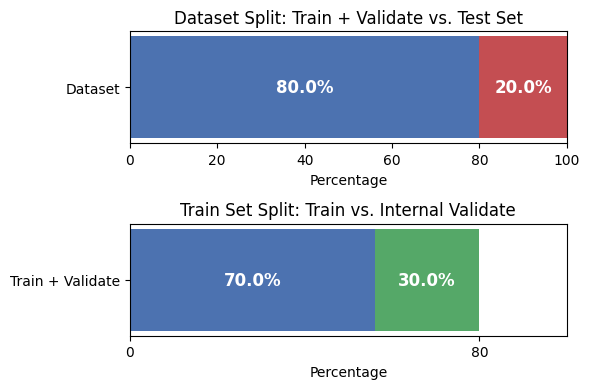

In [14]:
# Define preprocess_and_split function
def preprocess_and_split(data, test_size=0.2, validate_size=0.3, random_state=42):
    # Ensure the 'label' column is binary
    if data['label'].nunique() != 2:
        raise ValueError("Label column should contain exactly two unique values: 0 (normal) and 1 (cancer)")

    # Split combined data into train+validate (80%) and test (20%) sets
    train_temp, test = train_test_split(data, test_size=test_size, random_state=random_state, stratify=data['label'])

    # Split train_temp data into train (70% of train_temp) and validate (30% of train_temp) sets
    train, validate = train_test_split(train_temp, test_size=validate_size, random_state=random_state, stratify=train_temp['label'])

    # Print shapes of train, validate, and test sets
    print("Train:", train.shape)
    print("Validate:", validate.shape)
    print("Test:", test.shape)

    return train, validate, test


# Call preprocess_and_split function with combined cancer and healthy dataset
random_state = 42  # Set the seed value for reproducibility otherwise each time running the cell give me random combinations
train, validate, test = preprocess_and_split(combined_data, test_size=0.2, random_state=random_state)

# Define plot_split_distribution function
def plot_split_distribution(train, validate, test):
    total = len(train) + len(validate) + len(test)
    train_total = len(train) + len(validate)
    train_validate_pct = train_total / total * 100
    test_pct = len(test) / total * 100
    train_pct = len(train) / train_total * 100
    validate_pct = len(validate) / train_total * 100

    plt.figure(figsize=(6, 4))

    # Plot 80-20 split
    ax1 = plt.subplot(2, 1, 1)
    ax1.barh('Dataset', train_validate_pct, color='#4c72b0', label='Train + Validate')
    ax1.barh('Dataset', test_pct, left=train_validate_pct, color='#c44e52', label='Test')
    ax1.set_title('Dataset Split: Train + Validate vs. Test Set')
    ax1.set_xlabel('Percentage')
    ax1.set_xlim(0, 100)

    ax1.text(train_validate_pct / 2, 0, f'{train_validate_pct:.1f}%', ha='center', va='center', fontsize=12, color='white', weight='bold')
    ax1.text(train_validate_pct + test_pct / 2, 0, f'{test_pct:.1f}%', ha='center', va='center', fontsize=12, color='white', weight='bold')

    # Plot the split within the 80% train + validate set
    ax2 = plt.subplot(2, 1, 2)
    ax2.barh('Train + Validate', train_pct * 0.8, color='#4c72b0', label='Train')
    ax2.barh('Train + Validate', validate_pct * 0.8, left=train_pct * 0.8, color='#55a868', label='Internal Validate')
    ax2.set_title('Train Set Split: Train vs. Internal Validate')
    ax2.set_xlabel('Percentage')
    ax2.set_xlim(0, 100)
    ax2.set_xticks([0, 80])
    ax2.set_xticklabels(['0', '80'])

    ax2.text(train_pct * 0.8 / 2, 0, f'{train_pct:.1f}%', ha='center', va='center', fontsize=12, color='white', weight='bold')
    ax2.text(train_pct * 0.8 + validate_pct * 0.8 / 2, 0, f'{validate_pct:.1f}%', ha='center', va='center', fontsize=12, color='white', weight='bold')

    plt.tight_layout()
    plt.show()

# Plot the dataset split
plot_split_distribution(train, validate, test)

## **PCA**


**Principal Component Analysis** is a dimensionality reduction technique and I use it here to better visualize my data!

This simplification not only makes it easier to visualize and interpret differences between cancerous and normal tissues but also enhances the efficiency and performance of my machine learning models by focusing on the most informative features.

In [15]:
#as in earlier steps I changed suffixes and it causes some PCA difficulties so I restructure datasets and colors again here:

datasets = {
    "Breast": {"cancer": "breast invasive carcinoma", "normal": "Breast - Mammary Tissue"},
    "Uterine": {"cancer": "uterine corpus endometrial carcinoma", "normal": "Uterus"},
    "Kidney": {"cancer": ["kidney renal clear cell carcinoma", "kidney renal papillary cell carcinoma"], "normal": ["Kidney - Cortex", "kidney chromophobe"]},
    "Lung": {"cancer": ["lung adenocarcinoma", "lung squamous cell carcinoma"], "normal": "Lung"},
    "Thyroid": {"cancer": "thyroid carcinoma", "normal": "Thyroid"},
    "Prostate": {"cancer": "prostate adenocarcinoma", "normal": "Prostate"},
    "Colon": {"cancer": "colon adenocarcinoma", "normal": ["Colon - Transverse", "Colon - Sigmoid"]},
    "Stomach": {"cancer": "stomach adenocarcinoma", "normal": "Stomach"},
    "Liver": {"cancer": "liver hepatocellular carcinoma", "normal": "Liver"}
}

# Define colors for tissue subsets
colors = {
    "breast invasive carcinoma": "navajowhite",
    "Breast - Mammary Tissue": "tan",
    "uterine corpus endometrial carcinoma": "darkgreen",
    "Uterus": "yellowgreen",
    "kidney renal clear cell carcinoma": "darkorange",
    "kidney renal papillary cell carcinoma": "goldenrod",
    "Kidney - Cortex": "gold",
    "kidney chromophobe": "yellow",
    "lung adenocarcinoma": "lightpink",
    "lung squamous cell carcinoma": "skyblue",
    "Lung": "crimson",
    "thyroid carcinoma": "navy",
    "Thyroid": "dodgerblue",
    "prostate adenocarcinoma": "purple",
    "Prostate": "mediumorchid",
    "colon adenocarcinoma": "sienna",
    "Colon - Transverse": "sandybrown",
    "Colon - Sigmoid": "peru",
    "stomach adenocarcinoma": "firebrick",
    "Stomach": "indianred",
    "liver hepatocellular carcinoma": "darkcyan",
    "Liver": "lightseagreen"
}


As I mentioned before : I have fun with colorful plots ✌

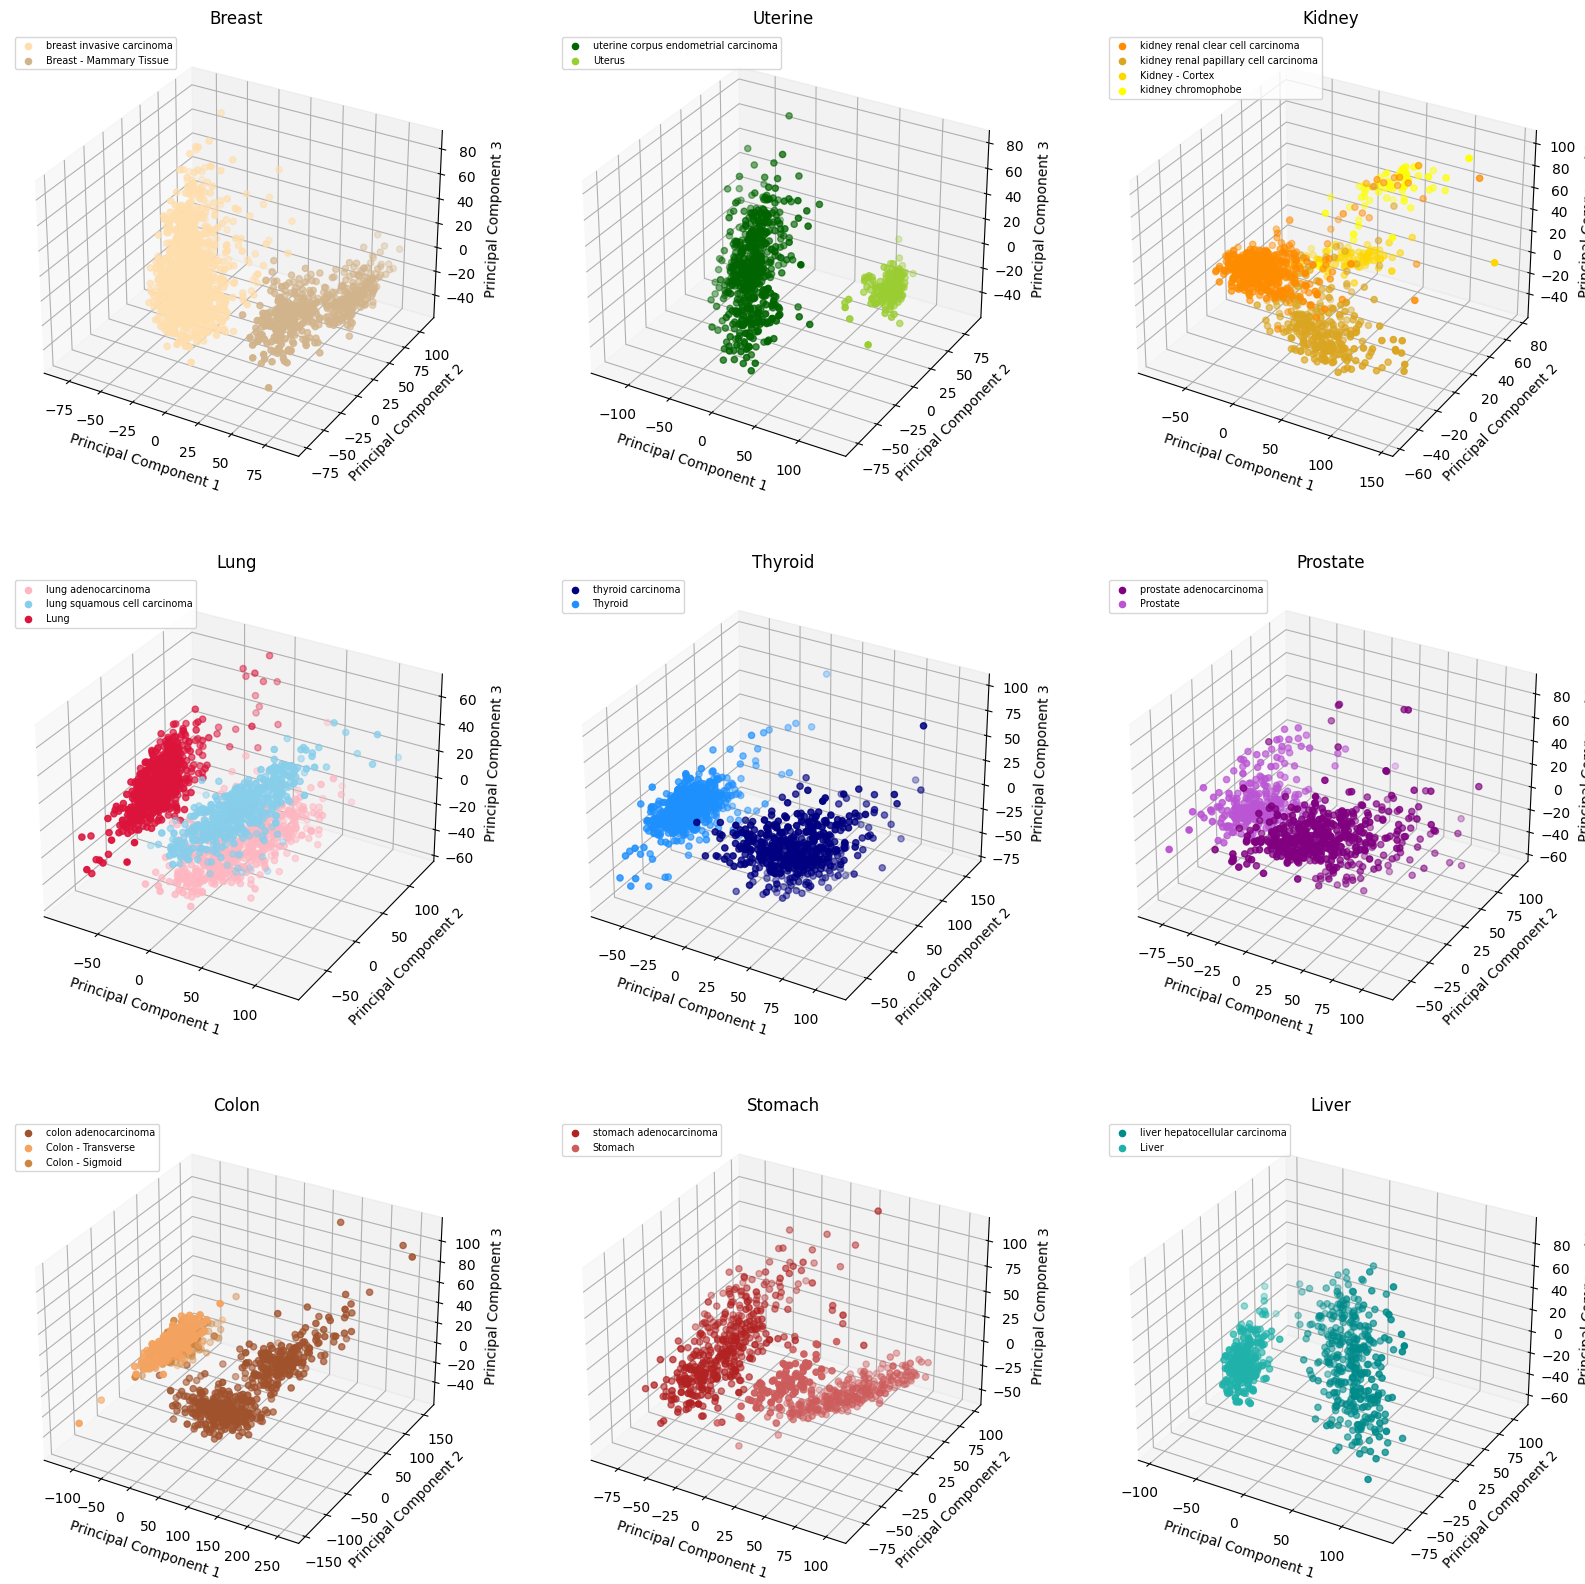

In [16]:
def perform_pca_and_plot(data, tissue_colors, ax, title):
    # Drop label column
    data_no_label = data.drop('label', axis=1)

    # Log scale the data
    x = data_no_label.loc[:, data_no_label.columns.drop(['tissue'])].values
    x = np.log(x + 0.01)  # add pseudo-counts

    # Fit PCA
    pca = PCA(n_components=3)
    principal_components = pca.fit_transform(x)
    df_pca = pd.DataFrame(data=principal_components, columns=['principal component 1', 'principal component 2', 'principal component 3'])

    # Add colors
    df_pca['color'] = data['tissue'].map(tissue_colors)

    # Plot data
    for tissue, color in tissue_colors.items():
        subset = df_pca[data['tissue'] == tissue]
        ax.scatter(subset['principal component 1'], subset['principal component 2'], subset['principal component 3'], c=color, label=tissue)

    # Set labels and legend
    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')
    ax.set_zlabel('Principal Component 3')
    ax.legend(loc='upper left', fontsize='x-small')
    ax.set_title(title)

# Assuming train, validate, test, datasets, and colors are already defined
# Plot PCA for each dataset
fig, axes = plt.subplots(3, 3, figsize=(20, 20), subplot_kw={'projection': '3d'})
axes = axes.flatten()

for i, (key, value) in enumerate(datasets.items()):
    cancer_keys = value['cancer']
    normal_keys = value['normal']

    # Ensure cancer_keys and normal_keys are lists
    if not isinstance(cancer_keys, list):
        cancer_keys = [cancer_keys]
    if not isinstance(normal_keys, list):
        normal_keys = [normal_keys]

    subset_data = pd.concat([data[data['tissue'] == tissue] for tissue in cancer_keys + normal_keys], ignore_index=True)

    # Create a dictionary of tissue colors for cancer and normal tissues
    tissue_colors = {tissue: colors[tissue] for tissue in cancer_keys + normal_keys}

    # Perform PCA and plot
    perform_pca_and_plot(subset_data, tissue_colors, axes[i], key)

plt.show()

I like how well the clustering is obviouse here, so we can train our model on each data blonging to the specific cluster and that means when the model learned from the provided data then we can expect it predict a given data point is either cancerous or normal.

This is called **supervised learning**! and next I want to compare some of it's methods on my datasets.

### the well separated clusters are from ***Breast* , *Uterine*, *Thyroid* , *Prostate*, *Stomach*** and ***Liver*,** so I expect an easy detection.


# **3.Training and Evaluating Models**



## **Logistic regression, Random forrest and K-nearest neighbors (KNN)**

But how we measure the performance of the model?

How to know the model is accurate?

Would it be more dangerous if the model falsly predicts a sample as cancerous or falsly skip a positive one?

 In first case probably they redo the test but in the second case, someone may
  **die**  without being diagnosed ❌ obviously not wanted ❌

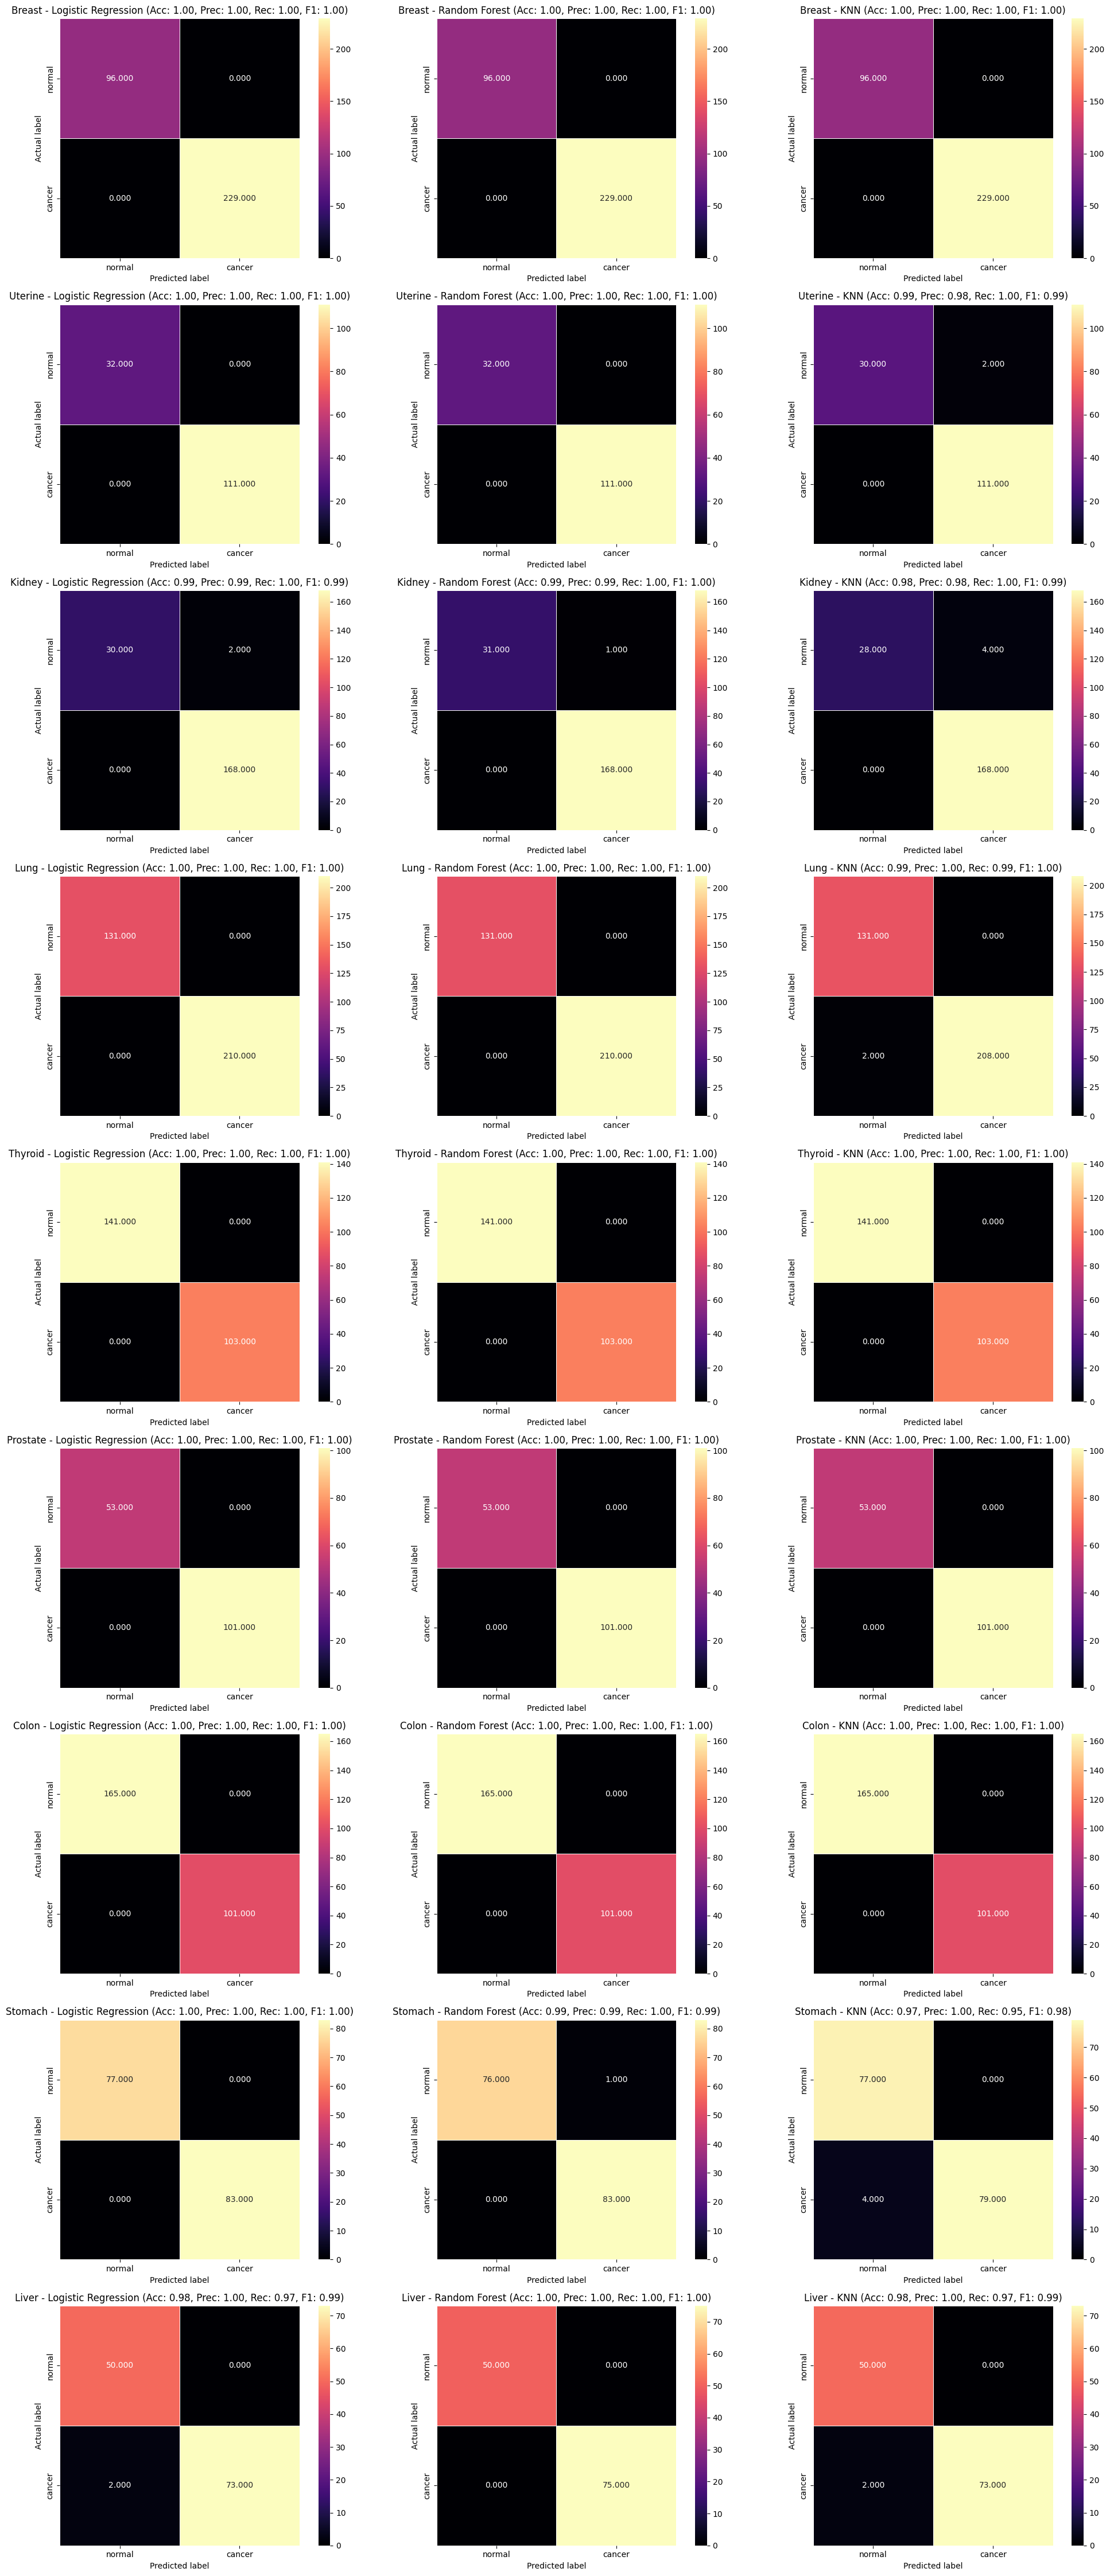

In [6]:
# Define preprocess_and_split function
def preprocess_and_split(data, test_size=0.2, validate_size=0.3, random_state=42):
    # Ensure the 'label' column is binary
    if data['label'].nunique() != 2:
        raise ValueError("Label column should contain exactly two unique values: 0 (normal) and 1 (cancer)")

    # Split combined data into train+validate (80%) and test (20%) sets
    train_temp, test = train_test_split(data, test_size=test_size, random_state=random_state, stratify=data['label'])

    # Split train_temp data into train (70% of train_temp) and validate (30% of train_temp) sets
    train, validate = train_test_split(train_temp, test_size=validate_size, random_state=random_state, stratify=train_temp['label'])

    # Print shapes of train, validate, and test sets
    #print("Train:", train.shape)
    #print("Validate:", validate.shape)
    #print("Test:", test.shape)

    return train, validate, test

# Define plot_heatmap function
def plot_heatmap(cm, class_names, ax, title):
    sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square=True, cmap='magma',
                xticklabels=class_names, yticklabels=class_names, ax=ax)
    ax.set_ylabel('Actual label')
    ax.set_xlabel('Predicted label')
    ax.set_title(title)

# Define train_and_evaluate_model function
def train_and_evaluate_model(model, x_train, y_train, x_test, y_test):
    model.fit(x_train, y_train)
    predictions = model.predict(x_test)
    cm = confusion_matrix(y_test, predictions)
    score = accuracy_score(y_test, predictions)
    precision = precision_score(y_test, predictions)
    recall = recall_score(y_test, predictions)
    f1 = f1_score(y_test, predictions)
    return cm, score, precision, recall, f1

# Load the dataset
data = pd.read_csv("drive/MyDrive/ML_course/final_project/gtex_with_cancer.csv.gz", sep="\t")

# Encode labels with 1 if it is cancerous and 0 if it is healthy and add a label column to the DataFrame
data['label'] = [1 if 'carcinoma' in x or 'adenocarcinoma' in x else 0 for x in data['tissue']]

# Filter dataset to include only tissues with counts above 250
tissue_counts = data['tissue'].value_counts()
high_count_tissues = tissue_counts[tissue_counts >= 250].index.tolist()
data_high_counts = data[data['tissue'].isin(high_count_tissues)]

# Filter the DataFrame to include only rows where the label is 1 (indicating cancer)
cancer_data = data_high_counts[data_high_counts['label'] == 1]

# Filter the DataFrame to include only rows where the label is 0 (indicating normal tissue)
normal_data = data[data['label'] == 0]

# Concatenate cancer and normal datasets into a single DataFrame
combined_data = pd.concat([cancer_data, normal_data], ignore_index=True)

# Define string_datasets variable
string_datasets = {
    "Breast": {"cancer": ["breast invasive carcinoma"], "normal": ["Breast - Mammary Tissue"]},
    "Uterine": {"cancer": ["uterine corpus endometrial carcinoma"], "normal": ["Uterus"]},
    "Kidney": {"cancer": ["kidney renal clear cell carcinoma", "kidney renal papillary cell carcinoma"], "normal": ["Kidney - Cortex", "kidney chromophobe"]},
    "Lung": {"cancer": ["lung adenocarcinoma", "lung squamous cell carcinoma"], "normal": ["Lung"]},
    "Thyroid": {"cancer": ["thyroid carcinoma"], "normal": ["Thyroid"]},
    "Prostate": {"cancer": ["prostate adenocarcinoma"], "normal": ["Prostate"]},
    "Colon": {"cancer": ["colon adenocarcinoma"], "normal": ["Colon - Transverse", "Colon - Sigmoid"]},
    "Stomach": {"cancer": ["stomach adenocarcinoma"], "normal": ["Stomach"]},
    "Liver": {"cancer": ["liver hepatocellular carcinoma"], "normal": ["Liver"]}
}

# Iterate through each dataset and train/evaluate models
fig, axes = plt.subplots(len(string_datasets), 3, figsize=(20, 45))

for idx, (key, value) in enumerate(string_datasets.items()):
    cancer_keys = value.get('cancer', [])
    normal_keys = value.get('normal', [])

    # Debug: Print tissue keys being processed
    #print(f"Processing {key} with cancer keys: {cancer_keys} and normal keys: {normal_keys}")

    # Filter combined_data based on cancer and normal keys
    cancer_data_subset_list = [combined_data[combined_data['tissue'] == tissue] for tissue in cancer_keys]
    normal_data_subset_list = [combined_data[combined_data['tissue'] == tissue] for tissue in normal_keys]

    # Check for empty data subsets before concatenating
    if all(subset.empty for subset in cancer_data_subset_list) or all(subset.empty for subset in normal_data_subset_list):
        print(f"Skipping {key} due to no data for one or both categories.")
        continue

    cancer_data_subset = pd.concat(cancer_data_subset_list, ignore_index=True)
    normal_data_subset = pd.concat(normal_data_subset_list, ignore_index=True)

    if cancer_data_subset.empty or normal_data_subset.empty:
        print(f"Skipping {key} due to no data for one or both categories after concatenation.")
        continue

    subset = pd.concat([cancer_data_subset, normal_data_subset])

    # Check if there are enough samples for each class
    #if subset['label'].value_counts().min() < 2:
    #    print(f"Skipping {key} due to insufficient samples for each class.")
    #    continue

    # Split data into train, validate, and test
    train, validate, test = preprocess_and_split(subset, test_size=0.2, random_state=42)
    x_train, y_train = train.drop(['label', 'tissue'], axis=1), train['label']
    x_test, y_test = test.drop(['label', 'tissue'], axis=1), test['label']

    # Train and evaluate Logistic Regression
    lr_model = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))
    lr_cm, lr_score, lr_precision, lr_recall, lr_f1 = train_and_evaluate_model(lr_model, x_train, y_train, x_test, y_test)
    plot_heatmap(lr_cm, ['normal', 'cancer'], axes[idx, 0], f'{key} - Logistic Regression (Acc: {lr_score:.2f}, Prec: {lr_precision:.2f}, Rec: {lr_recall:.2f}, F1: {lr_f1:.2f})')

    # Train and evaluate Random Forest Classifier
    rf_model = RandomForestClassifier()
    rf_cm, rf_score, rf_precision, rf_recall, rf_f1 = train_and_evaluate_model(rf_model, x_train, y_train, x_test, y_test)
    plot_heatmap(rf_cm, ['normal', 'cancer'], axes[idx, 1], f'{key} - Random Forest (Acc: {rf_score:.2f}, Prec: {rf_precision:.2f}, Rec: {rf_recall:.2f}, F1: {rf_f1:.2f})')

    # Train and evaluate K-Nearest Neighbors
    knn_model = make_pipeline(StandardScaler(), KNeighborsClassifier())
    knn_cm, knn_score, knn_precision, knn_recall, knn_f1 = train_and_evaluate_model(knn_model, x_train, y_train, x_test, y_test)
    plot_heatmap(knn_cm, ['normal', 'cancer'], axes[idx, 2], f'{key} - KNN (Acc: {knn_score:.2f}, Prec: {knn_precision:.2f}, Rec: {knn_recall:.2f}, F1: {knn_f1:.2f})')

plt.tight_layout()
plt.show()

### Conclusion from the Confusion Matrix and Scores

#### Confusion Matrix
- **Normal vs. Cancer**: Shows how many tissues were correctly or incorrectly classified as normal or cancerous.

#### Scores
- **Accuracy (Acc)**: How often the model is correct overall.
  -  Good for general performance, but can be misleading if classes are imbalanced.

- **Precision (Prec)**: How often the cancer predictions are correct.
  -  Important when false positives are costly.

- **Recall (Rec)**: How well the model identifies all actual cancers.
  -  Important when missing a cancer case is very costly.

- **F1-Score (F1)**: Balance between precision and recall.
  -  Useful as we need a balance between false positives and false negatives.






## **Verification Steps**

Verification steps are essential to ensure that our machine learning models are robust, reliable, and generalize well to unseen data. These steps help in identifying potential issues such as overfitting, data imbalance, and ensure that the models perform well in real-world scenarios. By systematically evaluating the models through various checks and metrics, we can build confidence in their predictive power and make necessary adjustments to improve their performance.



### Step 1: Check for Class Distribution
**Purpose**: To ensure the data is balanced and there are enough samples for both cancerous and normal tissues.
- Prints the number of samples for each class (normal and cancer) for each tissue type.

### Step 2: Cross-Validation
**Purpose**: To evaluate the model's performance and ensure it generalizes well to unseen data.
- Uses 5-fold cross-validation to calculate the average accuracy and standard deviation for each model.

### Step 3: Calculate Additional Metrics
**Purpose**: To get a detailed performance evaluation of each model.
- Computes precision, recall, and F1-score for each model, providing insights into how well the models identify cancerous tissues and avoid false positives.

### Step 4: Validation Dataset
**Purpose**: To further validate the model using a separate validation set, ensuring that the model is not overfitting and performs well on unseen data.
- Splits the data into training, validation, and test sets, then calculates the accuracy of each model on the validation set.

### Step 5: Testing on Separate Test Set
**Purpose**: To evaluate the models on a completely separate test set and ensure they generalize well to unseen data.
- Tests each model on the test set and prints accuracy, precision, recall, F1-score, and AUC-ROC to confirm performance.

### Step 6: Implementing Regularization
**Purpose**: To prevent overfitting by adding a penalty for larger coefficients in the model.
- Uses LogisticRegressionCV with cross-validation to apply regularization and evaluates the model's performance on the test set with comprehensive metrics.

### Step 7: Using More Robust Evaluation Metrics
**Purpose**: To ensure the models are not overfitting and have a balanced performance.
- Evaluates models using additional metrics such as precision, recall, F1-score, and AUC-ROC to provide a more comprehensive understanding of model performance.


In [18]:
# Step 1: Check for Class Distribution : this is shown as colorful plot in the begining. here is to check again
print("Step 1: Checking Class Distribution\n")
for key, value in string_datasets.items():
    cancer_keys = value.get('cancer', [])
    normal_keys = value.get('normal', [])

    if not isinstance(cancer_keys, list):
        cancer_keys = [cancer_keys]
    if not isinstance(normal_keys, list):
        normal_keys = [normal_keys]

    subset = combined_data[combined_data['tissue'].isin(cancer_keys + normal_keys)]
    class_counts = subset['label'].value_counts()
    print(f"{key} - distribution:")
    for label, count in class_counts.items():
        label_name = "Cancer" if label == 1 else "Normal"
        print(f"  {label_name}: {count}")
    print()

# Step 2: Cross-Validation
print("Step 2: Performing Cross-Validation\n")
for model in [LogisticRegression(max_iter=1000), RandomForestClassifier(), KNeighborsClassifier()]:
    pipeline = make_pipeline(StandardScaler(), model)
    X = combined_data.drop(['label', 'tissue'], axis=1)
    y = combined_data['label']
    scores = cross_val_score(pipeline, X, y, cv=5)
    print(f"{model.__class__.__name__} Cross-Validation Accuracy: {scores.mean():.2f} ± {scores.std():.2f}\n")

# Step 3: Calculate Additional Metrics
print("Step 3: Calculating Additional Metrics\n")
for model in [LogisticRegression(max_iter=1000), RandomForestClassifier(), KNeighborsClassifier()]:
    pipeline = make_pipeline(StandardScaler(), model)
    pipeline.fit(x_train, y_train)
    y_pred = pipeline.predict(x_test)
    print(f"{model.__class__.__name__}")
    print(f"  Precision: {precision_score(y_test, y_pred):.2f}")
    print(f"  Recall: {recall_score(y_test, y_pred):.2f}")
    print(f"  F1-Score: {f1_score(y_test, y_pred):.2f}\n")

# Step 4: Validation Dataset
print("Step 4: Validating the Model using the Validation Dataset\n")
train_temp, test = train_test_split(combined_data, test_size=0.2, random_state=42, stratify=combined_data['label'])
train, validate = train_test_split(train_temp, test_size=0.3, random_state=42, stratify=train_temp['label'])

print("Dataset Shapes:")
print(f"  Train set: {train.shape}")
print(f"  Validation set: {validate.shape}")
print(f"  Test set: {test.shape}\n")

for model in [LogisticRegression(max_iter=1000), RandomForestClassifier(), KNeighborsClassifier()]:
    pipeline = make_pipeline(StandardScaler(), model)
    pipeline.fit(train.drop(['label', 'tissue'], axis=1), train['label'])
    y_pred = pipeline.predict(validate.drop(['label', 'tissue'], axis=1))
    print(f"{model.__class__.__name__} Validation Accuracy: {accuracy_score(validate['label'], y_pred):.2f}\n")

Step 1: Checking Class Distribution

Breast - distribution:
  Cancer: 1142
  Normal: 482

Uterine - distribution:
  Cancer: 554
  Normal: 159

Kidney - distribution:
  Cancer: 837
  Normal: 160

Lung - distribution:
  Cancer: 1046
  Normal: 655

Thyroid - distribution:
  Normal: 706
  Cancer: 513

Prostate - distribution:
  Cancer: 506
  Normal: 263

Colon - distribution:
  Normal: 822
  Cancer: 505

Stomach - distribution:
  Cancer: 416
  Normal: 384

Liver - distribution:
  Cancer: 374
  Normal: 251

Step 2: Performing Cross-Validation

LogisticRegression Cross-Validation Accuracy: 0.97 ± 0.04

RandomForestClassifier Cross-Validation Accuracy: 0.96 ± 0.07

KNeighborsClassifier Cross-Validation Accuracy: 0.91 ± 0.05

Step 3: Calculating Additional Metrics

LogisticRegression
  Precision: 1.00
  Recall: 0.97
  F1-Score: 0.99

RandomForestClassifier
  Precision: 1.00
  Recall: 1.00
  F1-Score: 1.00

KNeighborsClassifier
  Precision: 1.00
  Recall: 0.97
  F1-Score: 0.99

Step 4: Validati

In [19]:
pipeline = make_pipeline(StandardScaler())

# Step 5: Testing on Separate Test Set
print("Step 5: Testing on Separate Test Set\n")
for model in [LogisticRegression(max_iter=1000), RandomForestClassifier(), KNeighborsClassifier()]:
    pipeline = make_pipeline(StandardScaler(), model)
    pipeline.fit(train.drop(['label', 'tissue'], axis=1), train['label'])
    y_pred = pipeline.predict(test.drop(['label', 'tissue'], axis=1))
    y_proba = pipeline.predict_proba(test.drop(['label', 'tissue'], axis=1))[:, 1]
    print(f"{model.__class__.__name__} Test Metrics:")
    print(f"  Accuracy: {accuracy_score(test['label'], y_pred):.2f}")
    print(f"  Precision: {precision_score(test['label'], y_pred):.2f}")
    print(f"  Recall: {recall_score(test['label'], y_pred):.2f}")
    print(f"  F1-Score: {f1_score(test['label'], y_pred):.2f}")
    print(f"  AUC-ROC: {roc_auc_score(test['label'], y_proba):.2f}\n")

# Step 6: Implementing Regularization
print("Step 6: Implementing Regularization\n")
lr_model = make_pipeline(StandardScaler(), LogisticRegressionCV(cv=5, max_iter=1000, random_state=42))
lr_model.fit(train.drop(['label', 'tissue'], axis=1), train['label'])
y_pred = lr_model.predict(test.drop(['label', 'tissue'], axis=1))
y_proba = lr_model.predict_proba(test.drop(['label', 'tissue'], axis=1))[:, 1]
print("LogisticRegressionCV Test Metrics:")
print(f"  Accuracy: {accuracy_score(test['label'], y_pred):.2f}")
print(f"  Precision: {precision_score(test['label'], y_pred):.2f}")
print(f"  Recall: {recall_score(test['label'], y_pred):.2f}")
print(f"  F1-Score: {f1_score(test['label'], y_pred):.2f}")
print(f"  AUC-ROC: {roc_auc_score(test['label'], y_proba):.2f}\n")

# Step 7: Using More Robust Evaluation Metrics
print("Step 7: Using More Robust Evaluation Metrics\n")
for model in [LogisticRegression(max_iter=1000), RandomForestClassifier(), KNeighborsClassifier()]:
    pipeline = make_pipeline(StandardScaler(), model)
    pipeline.fit(train.drop(['label', 'tissue'], axis=1), train['label'])
    y_pred = pipeline.predict(test.drop(['label', 'tissue'], axis=1))
    y_proba = pipeline.predict_proba(test.drop(['label', 'tissue'], axis=1))[:, 1]
    print(f"{model.__class__.__name__} Test Metrics:")
    print(f"  Accuracy: {accuracy_score(test['label'], y_pred):.2f}")
    print(f"  Precision: {precision_score(test['label'], y_pred):.2f}")
    print(f"  Recall: {recall_score(test['label'], y_pred):.2f}")
    print(f"  F1-Score: {f1_score(test['label'], y_pred):.2f}")
    print(f"  AUC-ROC: {roc_auc_score(test['label'], y_proba):.2f}\n")


Step 5: Testing on Separate Test Set

LogisticRegression Test Metrics:
  Accuracy: 1.00
  Precision: 0.99
  Recall: 1.00
  F1-Score: 1.00
  AUC-ROC: 1.00

RandomForestClassifier Test Metrics:
  Accuracy: 1.00
  Precision: 0.99
  Recall: 1.00
  F1-Score: 0.99
  AUC-ROC: 1.00

KNeighborsClassifier Test Metrics:
  Accuracy: 0.99
  Precision: 1.00
  Recall: 0.98
  F1-Score: 0.99
  AUC-ROC: 1.00

Step 6: Implementing Regularization

LogisticRegressionCV Test Metrics:
  Accuracy: 1.00
  Precision: 1.00
  Recall: 1.00
  F1-Score: 1.00
  AUC-ROC: 1.00

Step 7: Using More Robust Evaluation Metrics

LogisticRegression Test Metrics:
  Accuracy: 1.00
  Precision: 0.99
  Recall: 1.00
  F1-Score: 1.00
  AUC-ROC: 1.00

RandomForestClassifier Test Metrics:
  Accuracy: 1.00
  Precision: 0.99
  Recall: 1.00
  F1-Score: 1.00
  AUC-ROC: 1.00

KNeighborsClassifier Test Metrics:
  Accuracy: 0.99
  Precision: 1.00
  Recall: 0.98
  F1-Score: 0.99
  AUC-ROC: 1.00



The models show excellent performance across multiple metrics and verification steps, indicating they are robust and reliable on the current dataset. However, further validation with external data and continuous monitoring are essential to ensure that the models remain accurate and effective in real-world scenarios.



## **Finally : Neural Network!**

This part of the project involves constructing a neural network using PyTorch to classify cell data. The model first determines whether a given cell is cancerous or healthy. If the cell is identified as cancerous, a secondary classification step is performed to specify the type of cancer. The approach leverages PyTorch's flexibility and efficiency to train the model on labeled data, allowing it to automatically learn complex patterns and relationships within the dataset. This two-step classification ensures accurate detection and categorization of cancerous cells.







# **Prepare Data for Training**

This has been done before also but for simplicity of running cells separately at a time is included again.

In [20]:
# Function to define tissue subsets
def define_subsets(data, tissue_types):
    subsets = [data[data['tissue'] == tissue] for tissue in tissue_types]
    return pd.concat(subsets, ignore_index=True)

# Function to prepare data by dropping label column and encoding labels
def prepare_data(data):
    if 'label' in data:
        data = data.drop('label', axis=1)
    label_set = set(data['tissue'])
    label_dict = {label: i for i, label in enumerate(label_set)}
    data['tissue'] = data['tissue'].map(label_dict)
    class_names = [label for label, i in sorted(label_dict.items(), key=lambda item: item[1])]
    return data, class_names

# Function to split data into train, validation, and test sets
def split_data(data):
    train_temp, test = train_test_split(data, test_size=0.2, random_state=42)
    train, validate = train_test_split(train_temp, test_size=0.3, random_state=42)
    return train, validate, test

# Custom Dataset class for gene expression data
class GeneExpressionDataset(Dataset):
    def __init__(self, dataframe):
        self.data = dataframe.drop('tissue', axis=1).values
        self.labels = dataframe['tissue'].values

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

# Function to create DataLoader instances
def create_data_loaders(train, validate, test, batch_size=32):
    train_loader = DataLoader(GeneExpressionDataset(train), batch_size=batch_size, shuffle=True)
    validate_loader = DataLoader(GeneExpressionDataset(validate), batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(GeneExpressionDataset(test), batch_size=batch_size, shuffle=False)
    return train_loader, validate_loader, test_loader

# Define tissue types for lung and colon and Kkidney datasets
lung_tissue_types = ["lung adenocarcinoma", "lung squamous cell carcinoma", "Lung"]
colon_tissue_types = ["colon adenocarcinoma", "Colon - Transverse", "Colon - Sigmoid"]
# Define tissue types for kidney dataset
kidney_tissue_types = ["kidney renal clear cell carcinoma", "kidney renal papillary cell carcinoma",  "Kidney - Cortex", "kidney chromophobe"]

# Prepare lung data
data_lung = define_subsets(data, lung_tissue_types)
data_lung, lung_class_names = prepare_data(data_lung)
lung_train, lung_validate, lung_test = split_data(data_lung)
lung_train_loader, lung_validate_loader, lung_test_loader = create_data_loaders(lung_train, lung_validate, lung_test)

# Prepare colon data
data_colon = define_subsets(data, colon_tissue_types)
data_colon, colon_class_names = prepare_data(data_colon)
colon_train, colon_validate, colon_test = split_data(data_colon)
colon_train_loader, colon_validate_loader, colon_test_loader = create_data_loaders(colon_train, colon_validate, colon_test)

# Prepare kidney data
data_kidney = define_subsets(data, kidney_tissue_types)
data_kidney, kidney_class_names = prepare_data(data_kidney)
kidney_train, kidney_validate, kidney_test = split_data(data_kidney)
kidney_train_loader, kidney_validate_loader, kidney_test_loader = create_data_loaders(kidney_train, kidney_validate, kidney_test)

# **Define the Neural Network Model**

Various configurations of layer depths, neuron counts, activation functions, epochs, learning rates, and optimizers were systematically tested and adjusted during experimentation. The selection of optimal hyperparameters was guided by cross-validation and validation metrics to enhance model performance.

ended up with:
# Hyperparameters Set:

**Number of Layers:** 4 (including input and output layers)

**Number of Neurons:**
Layer 1 (fc1): 4000 neurons
Layer 2 (fc2): 1000 neurons
Layer 3 (fc3): 80 neurons
Layer 4 (fc4): Number of neurons equals the number of classes (variable for each dataset)

**Activation Function:** ReLU for hidden layers

**Number of Epochs:** 10

**Learning Rate:** 1e-4

**Loss Function:** CrossEntropyLoss

**Optimizer:** Adam


this is the part I tried different combination of different values of hyperparameters and this the how I ended up showing acceptebale level of performance as the model learnes but not overfits so I should take care of the balacing.

In [21]:
class Net(nn.Module):
    def __init__(self, input_size, num_classes):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, 4000)
        self.bn1 = nn.BatchNorm1d(4000)
        self.dropout1 = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(4000, 1000)
        self.bn2 = nn.BatchNorm1d(1000)
        self.dropout2 = nn.Dropout(p=0.5)
        self.fc3 = nn.Linear(1000, 80)
        self.bn3 = nn.BatchNorm1d(80)
        self.dropout3 = nn.Dropout(p=0.5)
        self.fc4 = nn.Linear(80, num_classes)

    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout1(x)
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout2(x)
        x = F.relu(self.bn3(self.fc3(x)))
        x = self.dropout3(x)
        x = self.fc4(x)
        return x

# **Training Mode Activated!**

After organizing the tissue data and understanding its distribution, the next step is to train our model! During training, the model learns from the data patterns, adjusting itself to make accurate predictions. It's like teaching our gene detective to recognize tissue types. 🕵️‍♂️💡

In [22]:
def train_and_validate(model, train_loader, validate_loader, num_epochs=10, learning_rate=1e-4, patience=3):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    best_validate_loss = float('inf')
    patience_counter = 0

    train_loss = []
    validate_loss = []
    train_acc = []
    validate_acc = []

    for epoch in range(num_epochs):
        epoch_train_loss = 0.0
        epoch_validate_loss = 0.0
        epoch_train_acc = 0.0
        epoch_validate_acc = 0.0

        model.train()
        for inputs, labels in train_loader:
            inputs = inputs.clone().detach().float()
            labels = labels.clone().detach().long()

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            epoch_train_loss += loss.item()
            loss.backward()
            optimizer.step()

            correct_pred = outputs.argmax(dim=1) == labels
            acc = correct_pred.sum() / len(correct_pred)
            epoch_train_acc += acc.item()

        model.eval()
        with torch.no_grad():
            for inputs, labels in validate_loader:
                inputs = inputs.clone().detach().float()
                labels = labels.clone().detach().long()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                epoch_validate_loss += loss.item()

                correct_pred = outputs.argmax(dim=1) == labels
                acc = correct_pred.sum() / len(correct_pred)
                epoch_validate_acc += acc.item()

        epoch_train_loss /= len(train_loader)
        epoch_validate_loss /= len(validate_loader)
        epoch_train_acc /= len(train_loader)
        epoch_validate_acc /= len(validate_loader)
        train_loss.append(epoch_train_loss)
        validate_loss.append(epoch_validate_loss)
        train_acc.append(epoch_train_acc)
        validate_acc.append(epoch_validate_acc)

        print(f"Epoch: {epoch+1}/{num_epochs}")
        print(f"Train Loss: {epoch_train_loss:.4f}, Validate Loss: {epoch_validate_loss:.4f}")
        print(f"Train Acc: {epoch_train_acc:.4f}, Validate Acc: {epoch_validate_acc:.4f}")

        # Early stopping
        if epoch_validate_loss < best_validate_loss:
            best_validate_loss = epoch_validate_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered")
                break

    return train_loss, validate_loss, train_acc, validate_acc


In [23]:
# Define model parameters
input_size_lung = data_lung.shape[1] - 1  # Number of features for lung data
input_size_colon = data_colon.shape[1] - 1  # Number of features for colon data
input_size_kidney = data_kidney.shape[1] - 1  # Number of features for kidney data
num_classes_lung = len(lung_class_names)
num_classes_colon = len(colon_class_names)
num_classes_kidney = len(kidney_class_names)

# Instantiate models
model_lung = Net(input_size_lung, num_classes_lung)
model_colon = Net(input_size_colon, num_classes_colon)
model_kidney = Net(input_size_kidney, num_classes_kidney)

# Train and validate models
print("Training Lung Model")
train_loss_lung, validate_loss_lung, train_acc_lung, validate_acc_lung = train_and_validate(model_lung, lung_train_loader, lung_validate_loader)

print("Training Colon Model")
train_loss_colon, validate_loss_colon, train_acc_colon, validate_acc_colon = train_and_validate(model_colon, colon_train_loader, colon_validate_loader)

print("Training Kidney Model")
train_loss_kidney, validate_loss_kidney, train_acc_kidney, validate_acc_kidney = train_and_validate(model_kidney, kidney_train_loader, kidney_validate_loader)


Training Lung Model
Epoch: 1/10
Train Loss: 0.5990, Validate Loss: 0.3783
Train Acc: 0.8090, Validate Acc: 0.9503
Epoch: 2/10
Train Loss: 0.3418, Validate Loss: 0.2698
Train Acc: 0.9392, Validate Acc: 0.9559
Epoch: 3/10
Train Loss: 0.2813, Validate Loss: 0.2383
Train Acc: 0.9559, Validate Acc: 0.9511
Epoch: 4/10
Train Loss: 0.2327, Validate Loss: 0.2103
Train Acc: 0.9538, Validate Acc: 0.9583
Epoch: 5/10
Train Loss: 0.2057, Validate Loss: 0.1946
Train Acc: 0.9649, Validate Acc: 0.9631
Epoch: 6/10
Train Loss: 0.1723, Validate Loss: 0.1793
Train Acc: 0.9792, Validate Acc: 0.9535
Epoch: 7/10
Train Loss: 0.1580, Validate Loss: 0.1764
Train Acc: 0.9781, Validate Acc: 0.9607
Epoch: 8/10
Train Loss: 0.1442, Validate Loss: 0.1590
Train Acc: 0.9812, Validate Acc: 0.9655
Epoch: 9/10
Train Loss: 0.1250, Validate Loss: 0.1519
Train Acc: 0.9833, Validate Acc: 0.9655
Epoch: 10/10
Train Loss: 0.1109, Validate Loss: 0.1427
Train Acc: 0.9892, Validate Acc: 0.9631
Training Colon Model
Epoch: 1/10
Train 

# **Conclusion:**

The models for lung, colon, and kidney show good learning behavior, with both training and validation losses decreasing and high accuracies being achieved. The validation performance is strong across all models, indicating good generalization.

# **Evaluation of the Model**

The evaluate_model function validates a trained model by calculating test loss and accuracy, indicating its performance on new data. This ensures the model's learning and generalization capabilities.

In [24]:
def evaluate_model(model, test_loader):
    criterion = nn.CrossEntropyLoss()
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.clone().detach().float()
            labels = labels.clone().detach().long()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_loss = running_loss / len(test_loader.dataset)
    accuracy = correct / total
    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {accuracy:.4f}')
    return test_loss, accuracy

# Evaluate lung model
print("Evaluating Lung Model")
test_loss_lung, test_accuracy_lung = evaluate_model(model_lung, lung_test_loader)

# Evaluate colon model
print("Evaluating Colon Model")
test_loss_colon, test_accuracy_colon = evaluate_model(model_colon, colon_test_loader)

# Evaluate kidney model
print("Evaluating Kidney Model")
test_loss_kidney, test_accuracy_kidney = evaluate_model(model_kidney, kidney_test_loader)


Evaluating Lung Model
Test Loss: 0.1201, Test Accuracy: 0.9824
Evaluating Colon Model
Test Loss: 0.2618, Test Accuracy: 0.9211
Evaluating Kidney Model
Test Loss: 0.3174, Test Accuracy: 0.9400


# **Model Performance Analysis**

Loss curves show model error over training epochs for both training and validation data. They help monitor training progress, detect overfitting, and determine when to stop training.

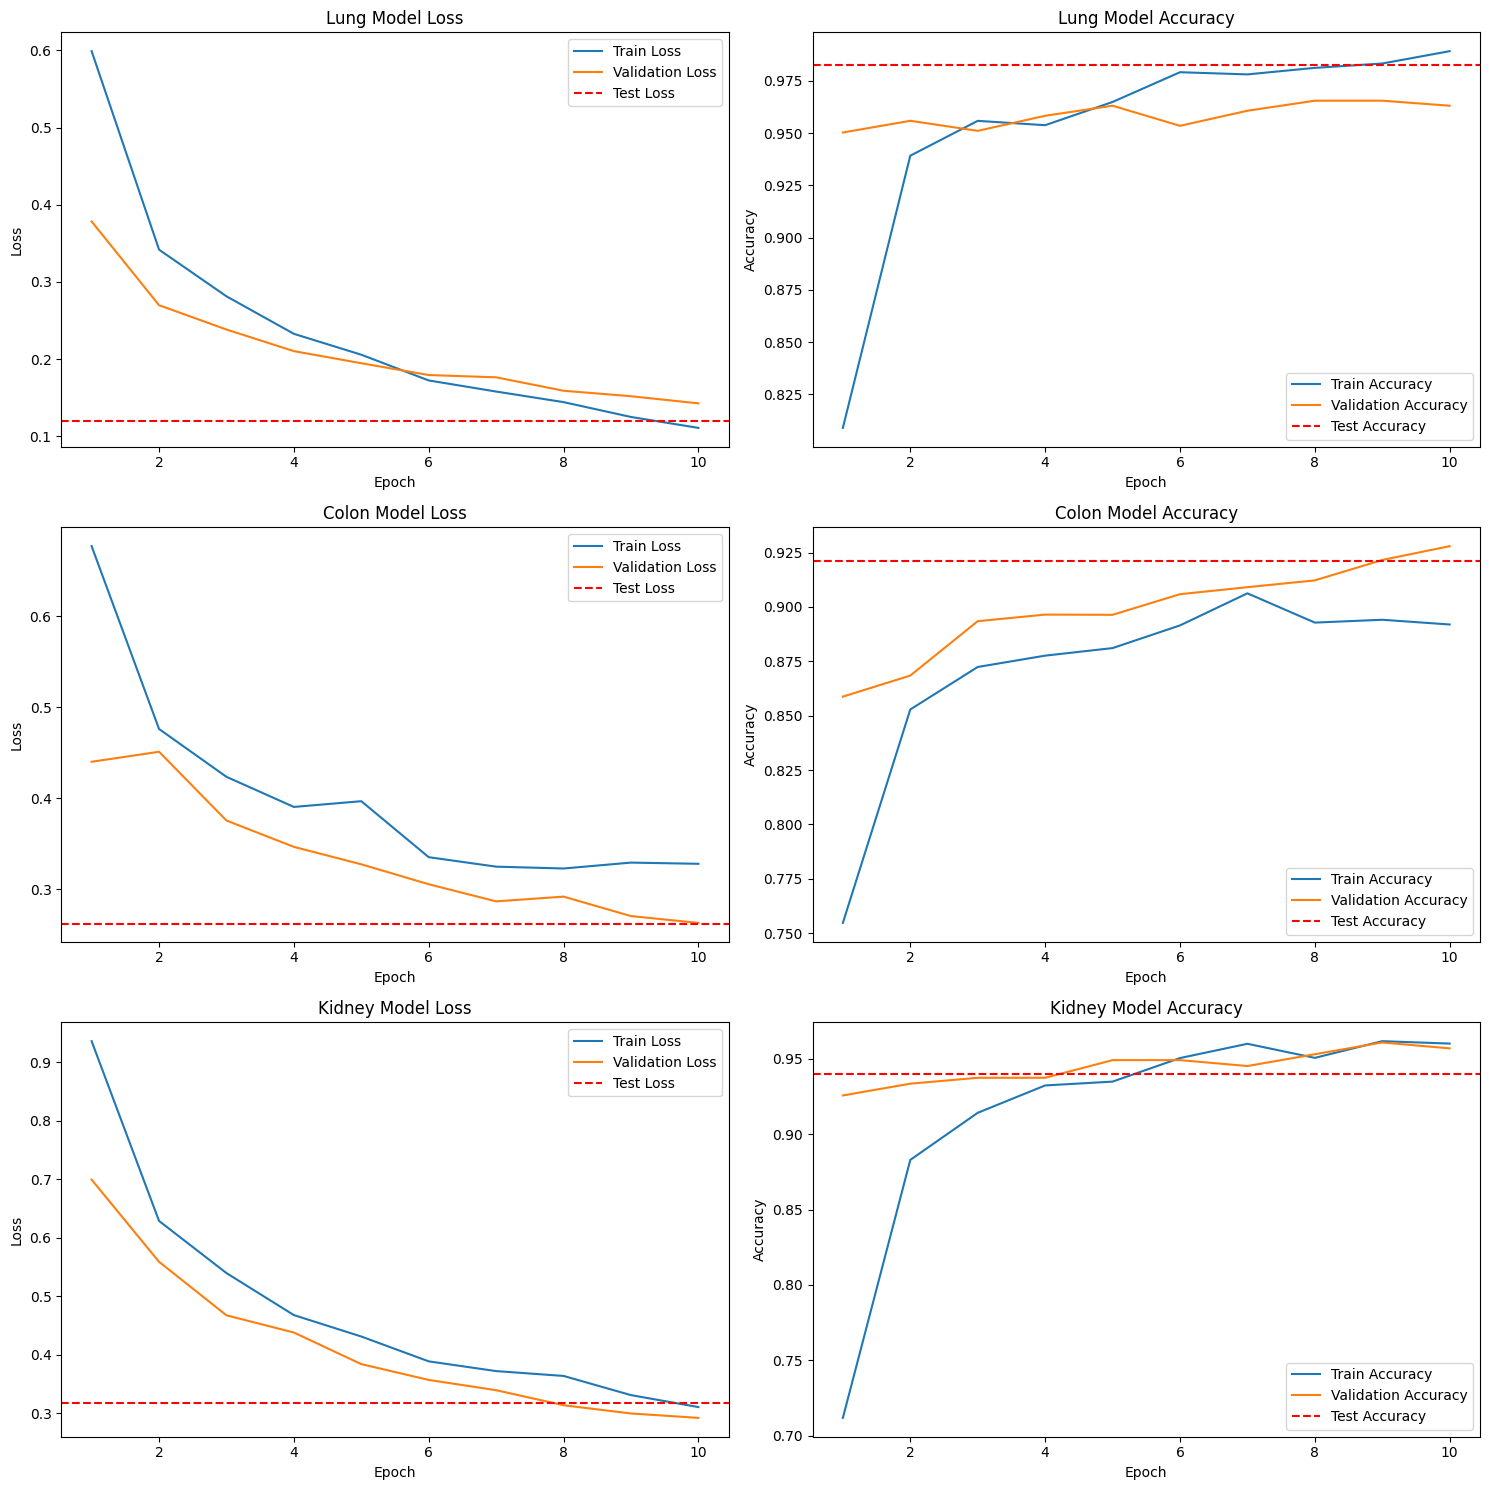

In [25]:
# Create a figure with 3 rows and 2 columns
fig, axes = plt.subplots(3, 2, figsize=(15, 15))

# Define a list of datasets and titles for easy iteration
datasets = [
    ("Lung", train_loss_lung, validate_loss_lung, train_acc_lung, validate_acc_lung, test_loss_lung, test_accuracy_lung),
    ("Colon", train_loss_colon, validate_loss_colon, train_acc_colon, validate_acc_colon, test_loss_colon, test_accuracy_colon),
    ("Kidney", train_loss_kidney, validate_loss_kidney, train_acc_kidney, validate_acc_kidney, test_loss_kidney, test_accuracy_kidney)
]

# Loop over the datasets and create the subplots
for i, (label, train_loss, validate_loss, train_acc, validate_acc, test_loss, test_acc) in enumerate(datasets):
    # Plot training and validation loss
    axes[i, 0].plot(np.arange(1, len(train_loss) + 1), train_loss, label="Train Loss")
    axes[i, 0].plot(np.arange(1, len(validate_loss) + 1), validate_loss, label="Validation Loss")
    axes[i, 0].axhline(y=test_loss, color='r', linestyle='--', label="Test Loss")
    axes[i, 0].legend()
    axes[i, 0].set_xlabel("Epoch")
    axes[i, 0].set_ylabel("Loss")
    axes[i, 0].set_title(f"{label} Model Loss")

    # Plot training and validation accuracy
    axes[i, 1].plot(np.arange(1, len(train_acc) + 1), train_acc, label="Train Accuracy")
    axes[i, 1].plot(np.arange(1, len(validate_acc) + 1), validate_acc, label="Validation Accuracy")
    axes[i, 1].axhline(y=test_acc, color='r', linestyle='--', label="Test Accuracy")
    axes[i, 1].legend()
    axes[i, 1].set_xlabel("Epoch")
    axes[i, 1].set_ylabel("Accuracy")
    axes[i, 1].set_title(f"{label} Model Accuracy")

# Adjust layout for better readability
plt.tight_layout()
plt.show()

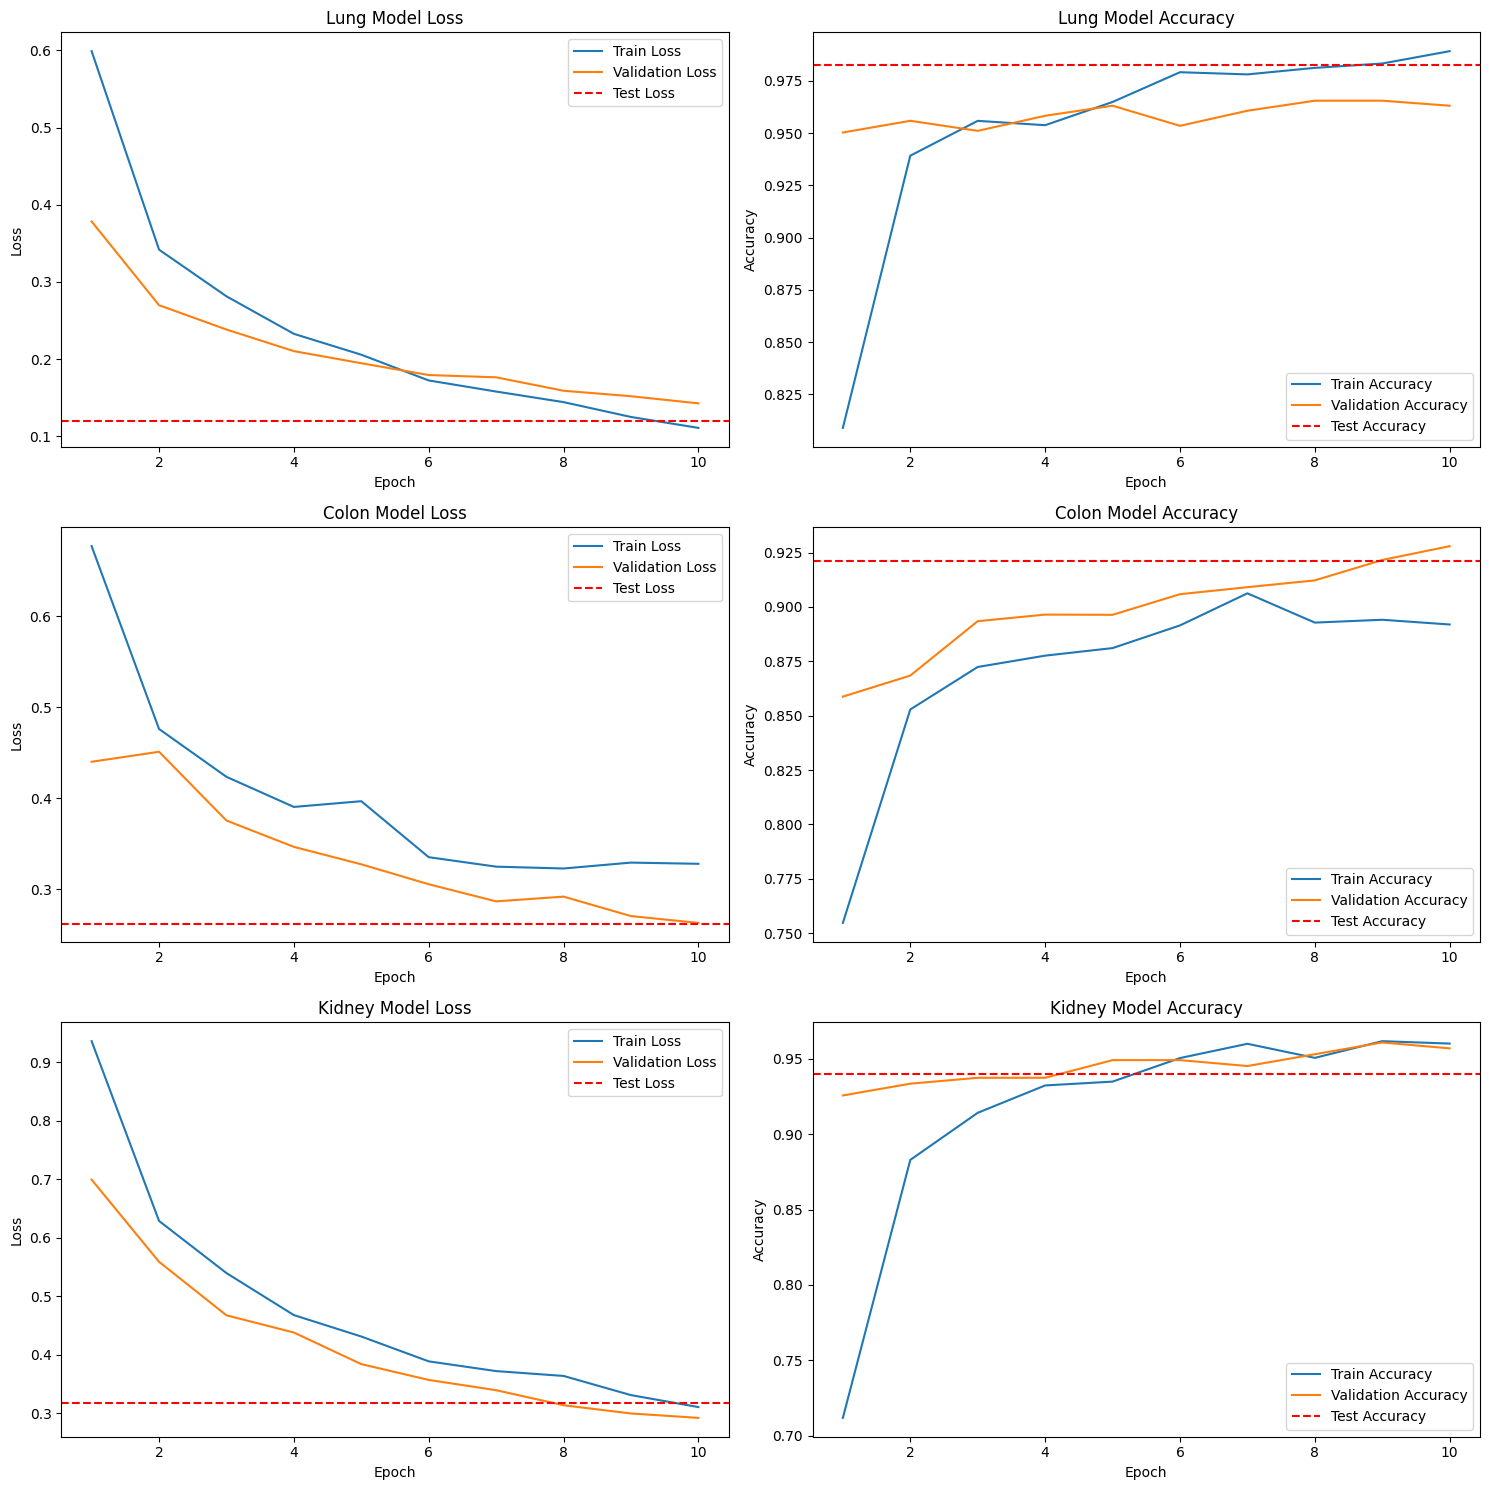

In [26]:
# Create a figure with 3 rows and 2 columns
fig, axes = plt.subplots(3, 2, figsize=(15, 15))

# Define a list of datasets and titles for easy iteration
datasets = [
    ("Lung", train_loss_lung, validate_loss_lung, train_acc_lung, validate_acc_lung, test_loss_lung, test_accuracy_lung),
    ("Colon", train_loss_colon, validate_loss_colon, train_acc_colon, validate_acc_colon, test_loss_colon, test_accuracy_colon),
    ("Kidney", train_loss_kidney, validate_loss_kidney, train_acc_kidney, validate_acc_kidney, test_loss_kidney, test_accuracy_kidney)
]

# Loop over the datasets and create the subplots
for i, (label, train_loss, validate_loss, train_acc, validate_acc, test_loss, test_acc) in enumerate(datasets):
    # Plot training and validation loss
    axes[i, 0].plot(np.arange(1, len(train_loss) + 1), train_loss, label="Train Loss")
    axes[i, 0].plot(np.arange(1, len(validate_loss) + 1), validate_loss, label="Validation Loss")
    axes[i, 0].axhline(y=test_loss, color='r', linestyle='--', label="Test Loss")
    axes[i, 0].legend()
    axes[i, 0].set_xlabel("Epoch")
    axes[i, 0].set_ylabel("Loss")
    axes[i, 0].set_title(f"{label} Model Loss")

    # Plot training and validation accuracy
    axes[i, 1].plot(np.arange(1, len(train_acc) + 1), train_acc, label="Train Accuracy")
    axes[i, 1].plot(np.arange(1, len(validate_acc) + 1), validate_acc, label="Validation Accuracy")
    axes[i, 1].axhline(y=test_acc, color='r', linestyle='--', label="Test Accuracy")
    axes[i, 1].legend()
    axes[i, 1].set_xlabel("Epoch")
    axes[i, 1].set_ylabel("Accuracy")
    axes[i, 1].set_title(f"{label} Model Accuracy")

# Adjust layout for better readability
plt.tight_layout()
plt.show()


For each model, training and validation loss and accuracy are plotted, with horizontal dashed lines indicating test metrics. This combined view facilitates quick assessment and comparison of different models' performance.

# **ROC Curves plot**

ROC curves are used to evaluate and compare the ability of multi-class classification models (for lung, colon, kidney datasets) to distinguish between different classes. They provide a visual representation of each model's performance across various classes, helping to assess how well the models classify specific conditions or types within their respective datasets.








In [27]:
# Define colors as I like to
colors = {
    "lung adenocarcinoma": "lightpink",
    "lung squamous cell carcinoma": "skyblue",
    "Lung": "crimson",
    "colon adenocarcinoma": "sienna",
    "Colon - Transverse": "sandybrown",
    "Colon - Sigmoid": "peru",
    "kidney renal clear cell carcinoma": "limegreen",
    "kidney renal papillary cell carcinoma": "forestgreen",
    "Kidney - Cortex": "darkgreen",
    "kidney chromophobe": "chartreuse"
}

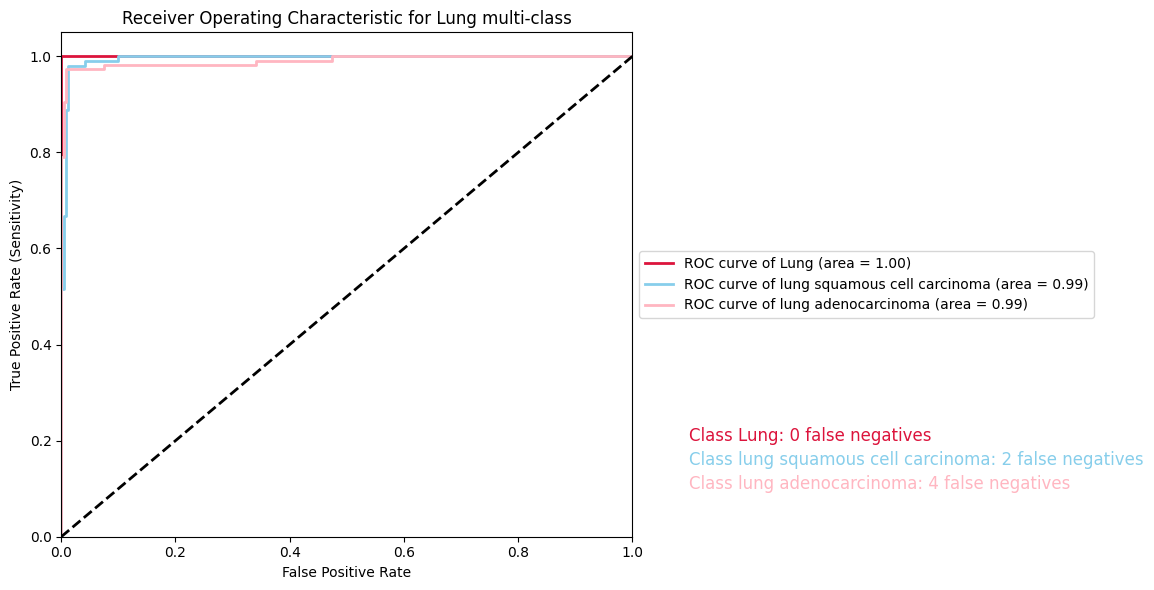

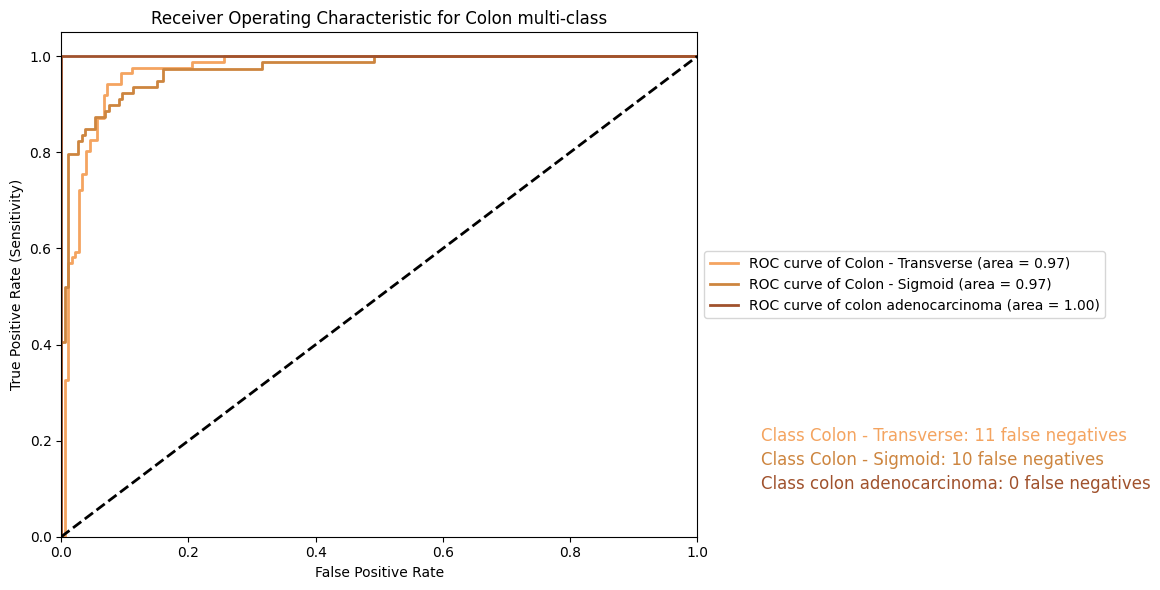

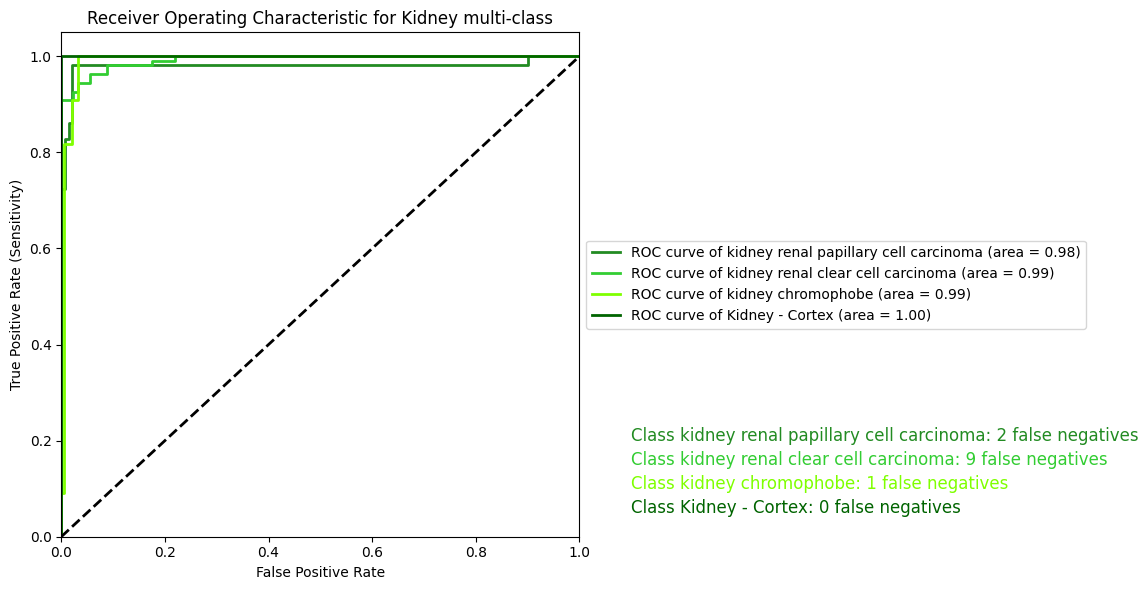

In [28]:
def plot_roc(model, test_loader, class_names, tissue_type):
    model.eval()
    n_classes = len(class_names)
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.clone().detach().float()
            labels = labels.clone().detach().long()
            outputs = model(inputs)
            probabilities = torch.softmax(outputs, dim=1)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(probabilities.cpu().numpy())

    all_labels = label_binarize(all_labels, classes=range(n_classes))
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    false_negatives = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(all_labels[:, i], [p[i] for p in all_predictions])
        roc_auc[i] = auc(fpr[i], tpr[i])

        # Calculate false negatives
        false_negatives[i] = np.sum((all_labels[:, i] == 1) & (np.argmax(all_predictions, axis=1) != i))

    # Plot all ROC curves
    plt.figure(figsize=(12, 6))

    for i, class_name in enumerate(class_names):
        color = colors[class_name]
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='ROC curve of {0} (area = {1:0.2f})'
                 ''.format(class_name, roc_auc[i]))

        # Add false negative counts to the plot
        plt.text(1.1, 0.2 - i * 0.05, f'Class {class_name}: {false_negatives[i]} false negatives', color=color, fontsize=12)

    # Plot the diagonal line representing random guessing
    plt.plot([0, 1], [0, 1], 'k--', lw=2)

    # Set plot limits and labels
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate (Sensitivity)')
    plt.title(f'Receiver Operating Characteristic for {tissue_type} multi-class')
    plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))  # Place the legend on the side
    plt.tight_layout()  # Adjust layout to prevent clipping of the legend
    plt.show()

# Plot ROC for lung model
plot_roc(model_lung, lung_test_loader, lung_class_names, "Lung")

# Plot ROC for colon model
plot_roc(model_colon, colon_test_loader, colon_class_names, "Colon")

# Plot ROC for kidney model
plot_roc(model_kidney, kidney_test_loader, kidney_class_names, "Kidney")
